In [39]:
# ALl IMPORTS
import os
import sys
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader
import pydicom
import matplotlib.image as mpimg
from scipy.ndimage import zoom
from skimage.transform import resize
import cv2
from sklearn.model_selection import train_test_split
import time
from tqdm.notebook import tqdm
from azure.storage.blob import ContainerClient
from tqdm import tqdm
import platform, psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time, os, traceback
import multiprocessing
from tqdm import tqdm
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, roc_curve, roc_auc_score
from torchinfo import summary
from ptflops import get_model_complexity_info
from torchvision.models.video import r2plus1d_18, r3d_18
from monai.networks.nets import DenseNet121, EfficientNetBN
import matplotlib.pyplot as plt
import seaborn as sns
import json
import psutil
import GPUtil
import joblib
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

In [28]:
def download_dataset(sas_url: str, output_dir: str = "ct_dataset"):

    os.makedirs(output_dir, exist_ok=True)

    container = ContainerClient.from_container_url(sas_url)
    print(f"Connected to container: {container.container_name}")
    print(f"Downloading files into: {output_dir}\n")

    for blob in container.list_blobs():
        local_path = os.path.join(output_dir, blob.name)
        os.makedirs(os.path.dirname(local_path), exist_ok=True)

        # Skip if file already fully downloaded
        if os.path.exists(local_path) and os.path.getsize(local_path) == blob.size:
            print(f"Skipping (already exists): {blob.name}")
            continue

        # Resume if partial file exists
        offset = 0
        mode = "wb"
        if os.path.exists(local_path):
            offset = os.path.getsize(local_path)
            if offset < blob.size:
                mode = "ab"  # append mode
                print(f"Resuming: {blob.name} (from {offset} bytes)")
            else:
                print(f"Skipping (complete): {blob.name}")
                continue

        # Download with progress bar
        stream = container.download_blob(blob.name, offset=offset)

        with open(local_path, mode) as f, tqdm(
            total=blob.size, initial=offset, unit="B", unit_scale=True,
            desc=blob.name, leave=False
        ) as pbar:
            for chunk in stream.chunks():
                f.write(chunk)
                pbar.update(len(chunk))

        print(f"Finished: {blob.name}")

    print("Download Complete")

In [ ]:
sas_url = "INSERT SINO_CT DATASET URL HERE" # REPLACE
download_dataset(sas_url, output_dir="ct_scans")

In [29]:
# Hardware & Software INFO 
print("GPU Name:", torch.cuda.get_device_name(0))
print("Total VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))
print("CPU:", platform.processor())
print("Cores:", psutil.cpu_count(logical=True))
print("RAM (GB):", round(psutil.virtual_memory().total / 1e9, 2))
print("CUDA version:", torch.version.cuda)
print("PyTorch version:", torch.__version__)

GPU Name: NVIDIA A40
Total VRAM (GB): 47.73
CPU: x86_64
Cores: 32
RAM (GB): 67.12
CUDA version: 12.8
PyTorch version: 2.8.0+cu128


In [33]:
# Label Preview
os.chdir("YOUR WORKING DIRECTORY HERE") # REPLACE
labels_df = pd.read_csv("ct_scans/head_ct_dataset_anon/labels.csv")
labels_df.columns = labels_df.columns.str.strip()  # remove hidden spaces
print(labels_df.head())

  patient_id label
0   series_0   0,1
1   series_1   0,1
2   series_2   0,1
3   series_3   0,1
4   series_4   0,1


In [34]:
# In Case of Incomplete Download
def is_in_downloaded_batches(patient_id, root_dir="ct_scans/head_ct_dataset_anon", batches=("batch_1", "batch_2", "batch_3", "batch_4", "batch_5", "batch_6", "batch_7", "batch_8", "batch_9")):
    """
    Check if a patient_id exists in the specified downloaded batch folders,
    and has both a sinogram.npy and a reconstructed_image folder.
    """
    for batch in batches:
        case_folder = os.path.join(root_dir, batch, patient_id)
        sino_path   = os.path.join(case_folder, "sinogram", "sinogram.npy")
        img_folder  = os.path.join(case_folder, "reconstructed_image")

        if os.path.exists(sino_path) and os.path.isdir(img_folder):
            return True
    return False

In [35]:
# Check Downloaded Batches
root_dir = "ct_scans/head_ct_dataset_anon"
batches = ["batch_1", "batch_2", "batch_3", "batch_4", "batch_5", "batch_6", "batch_7", "batch_8", "batch_9"]

# load master labels file
labels_df = pd.read_csv("ct_scans/head_ct_dataset_anon/labels.csv")

# collect patient IDs that exist in downloaded batches
valid_patients = []
for batch in batches:
    batch_path = os.path.join(root_dir, batch)
    if os.path.exists(batch_path):
        valid_patients.extend(os.listdir(batch_path))

labels_df = labels_df[labels_df["patient_id"].isin(valid_patients)].reset_index(drop=True)

print(f"Total patients in downloaded batches: {len(labels_df)}")

Total patients in downloaded batches: 9779


In [36]:
def make_splits(labels_df, split="70-15-15", seed=42):
    if split == "70-15-15":
        train_df, temp_df = train_test_split(
            labels_df,
            test_size=0.30,
            stratify=labels_df["label"],
            random_state=seed
        )
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.50,
            stratify=temp_df["label"],
            random_state=seed
        )
    elif split == "80-10-10":
        train_df, temp_df = train_test_split(
            labels_df,
            test_size=0.20,
            stratify=labels_df["label"],
            random_state=seed
        )
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.50,
            stratify=temp_df["label"],
            random_state=seed
        )
    else:
        raise ValueError("Only '70-15-15' or '80-10-10' splits are supported.")
    return train_df, val_df, test_df

In [37]:
def parse_label(label_str):
    """Parse one-hot string from labels.csv into 0 (normal) or 1 (abnormal)."""
    vals = [int(v) for v in str(label_str).replace('"','').split(",")]
    if vals == [0,1]:
        return 1  # abnormal
    elif vals == [1,0]:
        return 0  # normal
    else:
        raise ValueError(f"Unexpected label format: {vals}")

In [38]:
train_df, val_df, test_df = make_splits(labels_df, split="70-15-15")

train_df.to_csv("ct_scans/train_split.csv", index=False)
val_df.to_csv("ct_scans/val_split.csv", index=False)
test_df.to_csv("ct_scans/test_split.csv", index=False)

print("Class Balance:", labels_df["label"].apply(parse_label).value_counts().to_dict())

print(f"Split used: 70-15-15")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Class balance:")
print("Train:", train_df["label"].apply(parse_label).value_counts().to_dict())
print("Val:", val_df["label"].apply(parse_label).value_counts().to_dict())
print("Test:", test_df["label"].apply(parse_label).value_counts().to_dict())

Class Balance: {1: 5399, 0: 4380}
Split used: 70-15-15
Train: 6845 | Val: 1467 | Test: 1467
Class balance:
Train: {1: 3779, 0: 3066}
Val: {1: 810, 0: 657}
Test: {1: 810, 0: 657}


In [11]:
class CBFocalLoss(nn.Module):
    def __init__(self, class_counts, gamma=1.0, beta=0.99, smoothing=0.0):
        super().__init__()
        effective_num = 1.0 - np.power(beta, class_counts)
        weights = (1.0 - beta) / effective_num
        weights = weights / weights.sum() * len(class_counts)
        self.weights = torch.tensor(weights, dtype=torch.float32).to(device)
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(
            logits, targets, weight=self.weights,
            reduction="none", label_smoothing=self.smoothing
        )
        pt = torch.exp(-ce_loss)
        focal_term = (1 - pt) ** self.gamma
        return (focal_term * ce_loss).mean()

In [12]:
class AsymmetricFocalLoss(nn.Module):
    """
    Asymmetric Focal Loss:
    - gamma_pos: focus on hard positives (abnormal cases)
    - gamma_neg: focus on hard negatives (normal cases)
    """
    def __init__(self, class_counts=None, gamma_pos=0.5, gamma_neg=2.0):
        super().__init__()
        if class_counts is not None:
            weights = 1.0 / np.array(class_counts, dtype=np.float32)
            weights = weights / weights.sum() * len(class_counts)
            self.weights = torch.tensor(weights, dtype=torch.float32).to(device)
        else:
            self.weights = None
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.weights, reduction="none")
        pt = torch.exp(-ce_loss)
        # Separate gamma for pos vs neg
        gammas = torch.where(targets == 1, self.gamma_pos, self.gamma_neg)
        focal_term = (1 - pt) ** gammas
        return (focal_term * ce_loss).mean()

In [13]:
class HybridFocalCE(nn.Module):
    def __init__(self, class_counts, gamma=2.0, beta=0.9, lambda_focal=0.7):
        super().__init__()
        eff = 1.0 - np.power(beta, class_counts)
        w = (1.0 - beta) / np.array(eff)
        w = w / w.sum() * len(class_counts)
        self.register_buffer("weights", torch.tensor(w, dtype=torch.float32))
        self.gamma = gamma
        self.lambda_focal = lambda_focal

    def forward(self, logits, targets):
        # make sure weights are on the same device & dtype as logits
        weights = self.weights.to(logits.device, dtype=logits.dtype)

        ce = F.cross_entropy(logits, targets, weight=weights, reduction="none")
        pt = torch.exp(-ce)
        focal = ((1 - pt) ** self.gamma) * ce
        return self.lambda_focal * focal.mean() + (1 - self.lambda_focal) * ce.mean()

In [14]:
def make_balanced_loader(dataset, batch_size=2, factor=1.2):
    labels = np.array(dataset.labels)
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[l] for l in labels]

    # draw fewer samples to avoid extreme balancing
    num_samples = int(len(sample_weights) * factor)

    sampler = WeightedRandomSampler(sample_weights,
                                    num_samples=num_samples,
                                    replacement=True)

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

In [15]:
# Checking if using CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

Using device: cuda
True
NVIDIA A40


In [125]:
def train_model(model, train_dataset, val_dataset, num_epochs=15, lr=1e-4,
                ckpt_dir="checkpoints", patience=5, 
                loss_type="plain_ce", gamma=2.0, beta=0.9999,
                lambda_focal=0.5, balanced_sampler=False,
                batch_size=2, use_amp=True, device=None,
                results_dir="results", model_name="resnet3d", data_type="sinogram"):

    """
    Train a model with live tracking, early stopping, and auto-plotting.
    Automatically saves metrics CSV + training curves in results_dir.
    """

    # --- Setup ---
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    os.makedirs(ckpt_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

    # --- DataLoaders ---
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=not balanced_sampler,
        num_workers=4, pin_memory=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True
    )

    # --- Compute class stats ---
    labels = np.array(train_dataset.labels)
    class_counts = np.bincount(labels)
    print(f" Class counts: {class_counts.tolist()}")

    # --- Loss selection ---
    if loss_type == "hybrid":
        criterion = HybridFocalCE(class_counts, gamma=gamma, beta=beta, lambda_focal=lambda_focal)
    elif loss_type == "weighted_ce":
        class_weights = torch.tensor([0.43, 0.57]).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    elif loss_type == "mild_ce":
        weights = torch.tensor(class_counts.sum() / (1.25 * class_counts),
                               dtype=torch.float32, device=device)
        criterion = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.02)
    else:
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.05)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.amp.GradScaler("cuda") if (use_amp and device == "cuda") else None

    # --- Tracking setup ---
    best_val_acc, epochs_no_improve = 0.0, 0
    initial_ckpt_path = os.path.join(ckpt_dir, f"{data_type}_{model_name}temp_best.pt")
    metrics_path_short = os.path.join(results_dir, f"{data_type}_{model_name}_short_training_metrics.csv")
    metrics_path_full  = os.path.join(results_dir, f"{data_type}_{model_name}_training_metrics.csv")
    
    # --- Case 1: If we're resuming from an existing best checkpoint ---
    if os.path.exists(initial_ckpt_path):
        print(f"Found existing checkpoint: {initial_ckpt_path}")
    
        # Try to restore the previous best validation accuracy from metrics CSV
        if os.path.exists(metrics_path_full):
            best_val_acc = pd.read_csv(metrics_path_full)["val_acc"].max()
            print(f"Resuming {model_name} with previous best val_acc={best_val_acc:.4f} (full run)")
        if os.path.exists(metrics_path_short):
            temp_val_acc = pd.read_csv(metrics_path_short)["val_acc"].max()
            if temp_val_acc > best_val_acc:
                best_val_acc = pd.read_csv(metrics_path_short)["val_acc"].max()
                print(f"Resuming {model_name} with previous best val_acc={best_val_acc:.4f} (short run)")
        else:
            print("Metrics file not found, defaulting best_val_acc=0.0")
    
    # --- Case 2: Fresh training run (no previous checkpoint) ---
    else:
        print(f"No prior checkpoint found for {model_name}. Starting fresh.")
        ckpt_path = os.path.join(ckpt_dir, f"{data_type}_{model_name}_best.pt")
        torch.save(model.state_dict(), ckpt_path)
        print(f"Initial model checkpoint created: {ckpt_path}")
    
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "val_balacc": [], "val_f1": []
    }
    total_start = time.time()

    print(f"\nTraining {data_type.upper()} model ({model_name}) on {device.upper()} for {num_epochs} epochs...\n")

    # --- Epoch loop ---
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for X, y in loop:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=(scaler is not None)):
                outputs = model(X)
                loss = criterion(outputs, y)

            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            preds = outputs.argmax(1)
            train_loss += loss.item() * X.size(0)
            correct += (preds == y).sum().item()
            total += y.size(0)

            loop.set_postfix({
                "train_loss": f"{loss.item():.3f}",
                "train_acc": f"{(correct / total):.3f}"
            })

        scheduler.step()
        train_loss /= total
        train_acc = correct / total

        # --- Validation phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
                with torch.amp.autocast("cuda", enabled=(scaler is not None)):
                    outputs = model(X)
                    loss = criterion(outputs, y)
                preds = outputs.argmax(1)

                val_loss += loss.item() * X.size(0)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_balacc = balanced_accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average="weighted")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["val_balacc"].append(val_balacc)
        history["val_f1"].append(val_f1)

        print(f" Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss {train_loss:.4f}, Acc {train_acc:.3f} | "
              f"Val Loss {val_loss:.4f}, Acc {val_acc:.3f}, "
              f"BalAcc {val_balacc:.3f}, F1 {val_f1:.3f}")

        # --- Early stopping ---
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            ckpt_path = os.path.join(ckpt_dir, f"{data_type}_{model_name}_best.pt")
            torch.save(model.state_dict(), ckpt_path)
            print(f"New best model saved: {ckpt_path} (val_acc={val_acc:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    total_time = (time.time() - total_start) / 60
    print(f"\nTraining complete in {total_time:.2f} minutes. Best Val Acc = {best_val_acc:.4f}")

    # --- Save training history ---
    df_hist = pd.DataFrame(history)
    csv_path  = os.path.join(results_dir, f"{data_type}_{model_name}_training_metrics.csv")
    df_hist.to_csv(csv_path, index=False)
    print(f"Saved metrics to {csv_path}")

    # --- Auto plot ---
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], 'o-', label="Train Loss")
    plt.plot(epochs, history["val_loss"], 'o-', label="Val Loss")
    plt.title("Loss per Epoch"); plt.legend(); plt.grid(alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], 'o-', label="Train Acc")
    plt.plot(epochs, history["val_acc"], 'o-', label="Val Acc")
    plt.title("Accuracy per Epoch"); plt.legend(); plt.grid(alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["val_balacc"], 'o-', label="Balanced Acc")
    plt.plot(epochs, history["val_f1"], 'o-', label="Val F1")
    plt.title("Balanced Acc & F1 per Epoch"); plt.legend(); plt.grid(alpha=0.3)

    plt.suptitle(f"{data_type.upper()} {model_name.upper()} Training Summary")
    plt.tight_layout()
    plt.show()

    return model, history

In [20]:
def resnet3d(num_classes=2, in_channels=1, pretrained=False):
    model = r3d_18(weights=None if not pretrained else "KINETICS400_V1")
    if in_channels != 3:
        model.stem[0] = nn.Conv3d(in_channels, 64, kernel_size=(3,7,7),
                                  stride=(1,2,2), padding=(1,3,3), bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [21]:
def densenet3d(num_classes=2, in_channels=1):
    model = DenseNet121(
        spatial_dims=3,
        in_channels=in_channels,
        out_channels=num_classes,
        pretrained=False
    )
    return model

In [22]:
def efficientnet3d(num_classes=2, in_channels=1):
    model = EfficientNetBN(
        "efficientnet-b0",
        spatial_dims=3,
        in_channels=in_channels,
        num_classes=num_classes,
        pretrained=False
    )
    return model

In [23]:
def mobilenet3d(num_classes=2, in_channels=1):
    model = r2plus1d_18(weights=None)
    if in_channels != 3:
        model.stem[0] = nn.Conv3d(in_channels, 45, kernel_size=(3,7,7),
                                  stride=(1,2,2), padding=(1,3,3), bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [24]:
os.makedirs("results", exist_ok=True)

In [25]:
def profile_model(model, input_shape=(1,1,96,192,192)):
    """Profiles parameters, FLOPs, and mean inference time (ms)."""
    model = model.to("cuda")
    model.eval()
    with torch.cuda.device(0):
        macs, params = get_model_complexity_info(
            model, input_shape[1:], as_strings=False, print_per_layer_stat=False
        )
    x = torch.randn(*input_shape).to("cuda")
    torch.cuda.synchronize()
    start = time.time()
    _ = model(x)
    torch.cuda.synchronize()
    elapsed = (time.time() - start) * 1000
    return params / 1e6, macs / 1e9, elapsed  # Params (M), FLOPs (G), Time (ms)

In [26]:
profile_model(efficientnet3d(num_classes=2))

(4.690942, 4.830904058, 12.416839599609375)

In [27]:
profile_model(resnet3d(num_classes=2))

(33.148482, 11.377705986, 52.23560333251953)

In [28]:
profile_model(mobilenet3d(num_classes=2))

(31.301151, 718.856703234, 114.2730712890625)

In [29]:
profile_model(densenet3d(num_classes=2))

(11.244674, 73.23236557, 26.7636775970459)

In [192]:
def evaluate_model(
    model,
    loader,
    calibrator=None,
    device=None,
    thresholds=np.linspace(0.1, 0.9, 17),
    custom_thr=None,
    save_dir="results",
    prefix="eval"
):
    """
    Evaluate model with optional calibration, threshold optimization, and automatic saving.
    
    Args:
        model: trained PyTorch model
        loader: DataLoader for evaluation
        calibrator: optional calibrator (TemperatureScaler, IsotonicRegression, or callable)
        device: 'cuda' or 'cpu'
        thresholds: iterable thresholds to sweep
        custom_thr: fixed threshold (skip sweep)
        save_dir: folder to save confusion matrix, report, and predictions
        prefix: filename prefix for saving (e.g., 'sino_val', 'vol_test')
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    y_true, y_prob = [], []
    start = time.time()

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()

            # Apply calibration if available
            if calibrator is not None:
                if hasattr(calibrator, "predict"):  # sklearn-style (e.g., IsotonicRegression)
                    probs = calibrator.predict(probs)
                elif callable(calibrator):  # torch.nn.Module-style (e.g., TemperatureScaler)
                    with torch.no_grad():
                        logits_t = calibrator(outputs)
                        probs = torch.softmax(logits_t, dim=1)[:, 1].cpu().numpy()
                else:
                    raise TypeError("Calibrator must implement .predict() or be callable")

            y_true.extend(y.numpy())
            y_prob.extend(probs)

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # --- ROC AUC ---
    auc = roc_auc_score(y_true, y_prob)

    # --- Threshold sweep ---
    f1_scores, acc_scores = [], []
    best_thr, best_f1, best_acc, best_report, best_cm = 0.5, 0, 0, None, None
    thr_list = [custom_thr] if custom_thr is not None else thresholds

    for thr in thr_list:
        y_pred = (y_prob >= thr).astype(int)
        report = classification_report(y_true, y_pred,
                                       target_names=["Normal", "Abnormal"],
                                       output_dict=True, zero_division=0)
        f1 = report["Abnormal"]["f1-score"]
        acc = (y_pred == y_true).mean()
        f1_scores.append(f1)
        acc_scores.append(acc)

        recall_abn = report["Abnormal"]["recall"]
        if recall_abn > 0.7 and f1 > best_f1:
            best_thr, best_f1, best_acc = thr, f1, acc
            best_report = report
            best_cm = confusion_matrix(y_true, y_pred)

    # Fallback if none passed recall constraint
    if best_report is None:
        thr = 0.5 if custom_thr is None else custom_thr
        y_pred = (y_prob >= thr).astype(int)
        best_thr = thr
        best_report = classification_report(y_true, y_pred,
                                            target_names=["Normal", "Abnormal"],
                                            output_dict=True, zero_division=0)
        best_cm = confusion_matrix(y_true, y_pred)
        best_acc = (y_pred == y_true).mean()
        best_f1 = best_report["Abnormal"]["f1-score"]

    # --- Print Report ---
    print(f"Evaluation complete in {(time.time()-start)/60:.2f} minutes")
    print(f"Best threshold: {best_thr:.2f}")
    print(f"Accuracy: {best_acc:.4f}, F1: {best_f1:.4f}, ROC AUC: {auc:.4f}\n")
    print("--- Per-class Report ---")
    for cls in ["Normal", "Abnormal"]:
        p, r, f1 = best_report[cls]["precision"], best_report[cls]["recall"], best_report[cls]["f1-score"]
        print(f"{cls:8s}  P={p:.3f}, R={r:.3f}, F1={f1:.3f}")

    # --- Save JSON report ---
    save_path = os.path.join(save_dir, f"{prefix}_report.json")
    with open(save_path, "w") as f:
        json.dump({
            "threshold": float(best_thr),
            "accuracy": float(best_acc),
            "f1_abnormal": float(best_f1),
            "roc_auc": float(auc),
            "classification_report": best_report
        }, f, indent=4)
    print(f"Report saved to {save_path}")

    # --- Save raw predictions ---
    np.save(os.path.join(save_dir, f"{prefix}_y_true.npy"), y_true)
    np.save(os.path.join(save_dir, f"{prefix}_y_prob.npy"), y_prob)
    np.save(os.path.join(save_dir, f"{prefix}_y_pred.npy"), (y_prob >= best_thr).astype(int))
    print(f"Predictions saved to {save_dir}")

    # --- Confusion Matrix ---
    plt.figure(figsize=(6,5))
    sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal","Abnormal"], yticklabels=["Normal","Abnormal"])
    plt.title(f"Confusion Matrix @ thr={best_thr:.2f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    cm_path = os.path.join(save_dir, f"{prefix}_confusion_matrix.png")
    plt.savefig(cm_path, bbox_inches="tight", dpi=150)
    plt.show()
    print(f"Confusion matrix saved to {cm_path}")

    # --- F1 vs Threshold Plot ---
    if custom_thr is None:
        plt.figure(figsize=(6,4))
        plt.plot(thresholds, f1_scores, marker='o', label="F1 (Abnormal)")
        plt.plot(thresholds, acc_scores, marker='x', linestyle='--', label="Accuracy")
        plt.axvline(best_thr, color='r', linestyle=':', label=f"Best thr = {best_thr:.2f}")
        plt.title("F1 and Accuracy vs Threshold")
        plt.xlabel("Decision Threshold")
        plt.ylabel("Score")
        plt.legend()
        plt.grid(alpha=0.3)
        f1_plot_path = os.path.join(save_dir, f"{prefix}_f1_vs_threshold.png")
        plt.savefig(f1_plot_path, bbox_inches="tight", dpi=150)
        plt.show()
        print(f"F1-vs-threshold plot saved to {f1_plot_path}")

    return best_acc, best_f1, auc, best_cm, best_thr

In [189]:
def compare_curves(
    results_dirs,
    labels,
    prefixes=("eval", "eval"),
    save_path_roc="results/roc_comparison.png",
    save_path_pr="results/pr_comparison.png",
    dpi=150,
    n_bootstrap=1000,
    random_state=42
):
    """
    Compare ROC and PR curves for multiple evaluated models with
    statistical significance testing and 95% confidence intervals.
    """

    rng = np.random.default_rng(random_state)
    metrics_summary = {}

    # --- ROC Curve ---
    plt.figure(figsize=(7, 6))
    for dir_path, label in zip(results_dirs, labels):
        found = False
        for prefix in prefixes:
            true_path = os.path.join(dir_path, f"{prefix}_y_true.npy")
            prob_path = os.path.join(dir_path, f"{prefix}_y_prob.npy")
            if os.path.exists(true_path) and os.path.exists(prob_path):
                found = True
                break
        if not found:
            print(f"Missing predictions for {label}, skipping.")
            continue

        y_true = np.load(true_path)
        y_prob = np.load(prob_path)

        # --- Bootstrapped AUC ---
        auc_scores = []
        for _ in range(n_bootstrap):
            idx = rng.integers(0, len(y_true), len(y_true))
            try:
                auc_scores.append(roc_auc_score(y_true[idx], y_prob[idx]))
            except ValueError:
                continue
        auc_scores = np.array(auc_scores)
        auc_mean = np.mean(auc_scores)
        auc_ci = np.percentile(auc_scores, [2.5, 97.5])

        # Store results
        metrics_summary[label] = {
            "AUC": (auc_mean, auc_ci),
            "AUC_samples": auc_scores
        }

        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, lw=2,
                 label=f"{label} (AUC = {auc_mean:.3f} [{auc_ci[0]:.3f}-{auc_ci[1]:.3f}])")

    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC Curve Comparison", fontsize=14)
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path_roc, bbox_inches="tight", dpi=dpi)
    plt.show()
    print(f"ROC comparison saved to {save_path_roc}")

    # --- Precision–Recall Curve ---
    plt.figure(figsize=(7, 6))
    for dir_path, label in zip(results_dirs, labels):
        found = False
        for prefix in prefixes:
            true_path = os.path.join(dir_path, f"{prefix}_y_true.npy")
            prob_path = os.path.join(dir_path, f"{prefix}_y_prob.npy")
            if os.path.exists(true_path) and os.path.exists(prob_path):
                found = True
                break
        if not found:
            print(f"Missing PR data for {label}, skipping.")
            continue

        y_true = np.load(true_path)
        y_prob = np.load(prob_path)

        # --- Bootstrapped AP ---
        ap_scores = []
        for _ in range(n_bootstrap):
            idx = rng.integers(0, len(y_true), len(y_true))
            try:
                ap_scores.append(average_precision_score(y_true[idx], y_prob[idx]))
            except ValueError:
                continue
        ap_scores = np.array(ap_scores)
        ap_mean = np.mean(ap_scores)
        ap_ci = np.percentile(ap_scores, [2.5, 97.5])

        # Store AP samples
        metrics_summary[label]["AP"] = (ap_mean, ap_ci)
        metrics_summary[label]["AP_samples"] = ap_scores

        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        plt.plot(recall, precision, lw=2,
                 label=f"{label} (AP = {ap_mean:.3f} [{ap_ci[0]:.3f}-{ap_ci[1]:.3f}])")

    plt.xlabel("Recall (Sensitivity)", fontsize=12)
    plt.ylabel("Precision (PPV)", fontsize=12)
    plt.title("Precision–Recall Curve Comparison", fontsize=14)
    plt.legend(loc="lower left", fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path_pr, bbox_inches="tight", dpi=dpi)
    plt.show()
    print(f"Precision–Recall comparison saved to {save_path_pr}")

    
    if len(metrics_summary) == 2:
        models = list(metrics_summary.keys())
        auc1 = np.array(metrics_summary[models[0]]["AUC_samples"])
        auc2 = np.array(metrics_summary[models[1]]["AUC_samples"])
        ap1  = np.array(metrics_summary[models[0]]["AP_samples"])
        ap2  = np.array(metrics_summary[models[1]]["AP_samples"])

        # --- Paired bootstrap differences ---
        diff_auc = auc1 - auc2
        diff_ap  = ap1  - ap2

        # Two-sided p-value: fraction of bootstrap diffs crossing zero
        p_auc = 2 * min(np.mean(diff_auc > 0), np.mean(diff_auc < 0))
        p_ap  = 2 * min(np.mean(diff_ap  > 0), np.mean(diff_ap  < 0))

        auc_diff_mean = np.mean(diff_auc)
        ap_diff_mean  = np.mean(diff_ap)
        auc_diff_ci   = np.percentile(diff_auc, [2.5, 97.5])
        ap_diff_ci    = np.percentile(diff_ap,  [2.5, 97.5])

        print("\n=== Statistical Significance (Paired Bootstrap) ===")
        print(f"AUC Δ = {auc_diff_mean:.4f} "
              f"[{auc_diff_ci[0]:.4f}, {auc_diff_ci[1]:.4f}], p = {p_auc:.4f}")
        print(f"AP  Δ = {ap_diff_mean:.4f} "
              f"[{ap_diff_ci[0]:.4f}, {ap_diff_ci[1]:.4f}], p = {p_ap:.4f}")

        if (auc_diff_ci[0] <= 0 <= auc_diff_ci[1]) and (ap_diff_ci[0] <= 0 <= ap_diff_ci[1]):
            print("→ No significant difference detected.")
        else:
            print("→ Significant difference detected.")

    # --- Final Summary ---
    print("\n=== Summary of Performance Metrics ===")
    for label, metrics in metrics_summary.items():
        auc_m, auc_ci = metrics["AUC"]
        ap_m, ap_ci = metrics["AP"]
        print(f"{label}: AUC = {auc_m:.3f} [{auc_ci[0]:.3f}-{auc_ci[1]:.3f}], "
              f"AP = {ap_m:.3f} [{ap_ci[0]:.3f}-{ap_ci[1]:.3f}]")

In [157]:
# DATALOADER
try:
    multiprocessing.set_start_method('spawn', force=True)
except RuntimeError:
    pass  # already set

# --- Auto-detect if running in interactive environment (like Jupyter) ---
IS_INTERACTIVE = hasattr(sys, 'ps1') or 'ipykernel' in sys.modules
NUM_WORKERS = 0 if IS_INTERACTIVE else 4

print(f"DataLoader using num_workers={NUM_WORKERS} (interactive={IS_INTERACTIVE})")

def make_dataloader(dataset, batch_size=2, shuffle=False, pin_memory=True):
    """Safe DataLoader factory that adapts worker count to environment."""
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=pin_memory,
        persistent_workers=(NUM_WORKERS > 0)
    )

DataLoader using num_workers=0 (interactive=True)


In [232]:
from datasets import Sinogram3DDataset, Volume3DDataset

train_sino = Sinogram3DDataset("ct_scans/train_split.csv",
                               "ct_scans/head_ct_dataset_anon",
                               target_shape=(192,192,96),
                               batches=("batch_1","batch_2","batch_3", "batch_4", "batch_5", "batch_6", "batch_7", "batch_8",  "batch_9"))

val_sino   = Sinogram3DDataset("ct_scans/val_split.csv",
                               "ct_scans/head_ct_dataset_anon",
                               target_shape=(192,192,96),
                               batches=("batch_1","batch_2","batch_3", "batch_4", "batch_5", "batch_6", "batch_7", "batch_8", "batch_9"))

test_sino  = Sinogram3DDataset("ct_scans/test_split.csv",
                               "ct_scans/head_ct_dataset_anon",
                               target_shape=(192,192,96),
                               batches=("batch_1","batch_2","batch_3", "batch_4", "batch_5", "batch_6", "batch_7", "batch_8", "batch_9"))

train_vol = Volume3DDataset(
    "ct_scans/train_split.csv",
    "ct_scans/head_ct_dataset_anon",
    target_shape=(192,192,96)
)

val_vol = Volume3DDataset(
    "ct_scans/val_split.csv",
    "ct_scans/head_ct_dataset_anon",
    target_shape=(192,192,96)
)

test_vol = Volume3DDataset(
    "ct_scans/test_split.csv",
    "ct_scans/head_ct_dataset_anon",
    target_shape=(192,192,96)
)

#Sinogram loaders
train_loader_sino = make_dataloader(train_sino, batch_size=2, shuffle=True)
val_loader_sino   = make_dataloader(val_sino,   batch_size=2, shuffle=False)
test_loader_sino  = make_dataloader(test_sino,  batch_size=2, shuffle=False)

#Volume loaders
train_loader_vol = make_dataloader(train_vol, batch_size=2, shuffle=True)
val_loader_vol   = make_dataloader(val_vol,   batch_size=2, shuffle=False)
test_loader_vol  = make_dataloader(test_vol,  batch_size=2, shuffle=False)

In [35]:
# CHECKING
xb, yb = next(iter(train_loader_sino))
print("Sino batch:", xb.shape)   # (B, 1, D, H, W)

xb, yb = next(iter(train_loader_vol))
print("Vol batch:", xb.shape)   # (B, 1, D, H, W)

Sino batch: torch.Size([2, 1, 192, 192, 96])
Vol batch: torch.Size([2, 1, 192, 192, 96])


In [36]:
root_dir = "ct_scans/head_ct_dataset_anon"
batches = [f"batch_{i}" for i in range(1, 10)]  # adjust based on what you have downloaded

slice_counts = []

for batch in batches:
    batch_path = os.path.join(root_dir, batch)
    if not os.path.isdir(batch_path):
        continue

    for patient_id in os.listdir(batch_path):
        img_folder = os.path.join(batch_path, patient_id, "reconstructed_image")
        if os.path.isdir(img_folder):
            n_slices = len([f for f in os.listdir(img_folder) if f.endswith(".dcm")])
            if n_slices > 0:
                slice_counts.append(n_slices)

slice_counts = np.array(slice_counts)
print(f"Total patients analyzed: {len(slice_counts)}")
print(f"Min slices: {slice_counts.min()}, Max slices: {slice_counts.max()}, Median: {np.median(slice_counts)}")

Total patients analyzed: 9779
Min slices: 12, Max slices: 77, Median: 36.0


In [37]:
for i in range(5):
    print(train_sino.df.iloc[i]["patient_id"], "->", train_sino.labels[i])

series_2163 -> 0
series_2171 -> 0
series_9384 -> 0
series_6481 -> 0
series_4246 -> 0


In [38]:
class FastTemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, logits):
        # logits / T — ensures temperature is positive
        T = self.temperature.clamp(1e-3, 100.0)
        return logits / T

In [39]:
def fit_fast_temperature(model, val_loader, device="cuda", max_epochs=50, lr=1e-2, patience=5):
    """
    Fast batched temperature scaling for model calibration.
    """
    model.eval()
    scaler = FastTemperatureScaler().to(device)
    optimizer = torch.optim.Adam([scaler.temperature], lr=lr)

    best_loss = float("inf")
    no_improve = 0
    losses = []

    print("[Cal] Starting fast temperature fitting...")

    for epoch in range(max_epochs):
        running_loss = 0.0
        n_samples = 0

        for X, y in tqdm(val_loader, leave=False):
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                logits = model(X)
            logits_T = scaler(logits)
            loss = F.cross_entropy(logits_T, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y.size(0)
            n_samples += y.size(0)

        avg_loss = running_loss / n_samples
        losses.append(avg_loss)

        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            best_T = scaler.temperature.item()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"[Cal] Early stop @ epoch {epoch+1}")
            break

    scaler.temperature.data.fill_(best_T)
    print(f"[Cal] Optimal temperature: {best_T:.3f}")
    return scaler

In [40]:
def exp_curve(epoch, A_inf, A0, k):
    return A_inf - (A_inf - A0) * np.exp(-k * epoch)

In [131]:
model_configs = {
    "resnet3d": resnet3d(num_classes=2),
    "densenet3d": densenet3d(num_classes=2, in_channels=1),
    "efficientnet3d": efficientnet3d(num_classes=2, in_channels=1),
    "mobilenet3d": mobilenet3d(num_classes=2, in_channels=1)
}

In [42]:
from scipy.optimize import curve_fit


Checking short-run status: RESNET3D
RESNET3D already completed 7 epochs — skipping retrain.

Checking short-run status: DENSENET3D
DENSENET3D has 0 epochs logged. Continuing for 7 more.
No checkpoint found, starting fresh.
 Class counts: [3779, 3066]

Training SINOGRAM model (densenet3d_short) on CUDA for 7 epochs...



Epoch 1/7: 100%|██████████| 3423/3423 [27:32<00:00,  2.07it/s, train_loss=0.748, train_acc=0.552]


 Epoch 1/7 | Train Loss 0.6904, Acc 0.552 | Val Loss 0.6557, Acc 0.640, BalAcc 0.632, F1 0.638
New best model saved: checkpoints/sinogram_densenet3d_short_best.pt (val_acc=0.6401)


Epoch 2/7: 100%|██████████| 3423/3423 [28:46<00:00,  1.98it/s, train_loss=0.559, train_acc=0.588]


 Epoch 2/7 | Train Loss 0.6728, Acc 0.588 | Val Loss 0.6431, Acc 0.639, BalAcc 0.643, F1 0.639


Epoch 3/7: 100%|██████████| 3423/3423 [24:36<00:00,  2.32it/s, train_loss=0.607, train_acc=0.604]


 Epoch 3/7 | Train Loss 0.6642, Acc 0.604 | Val Loss 0.7335, Acc 0.620, BalAcc 0.588, F1 0.578


Epoch 4/7: 100%|██████████| 3423/3423 [28:32<00:00,  2.00it/s, train_loss=0.368, train_acc=0.636]


 Epoch 4/7 | Train Loss 0.6464, Acc 0.636 | Val Loss 0.6259, Acc 0.669, BalAcc 0.652, F1 0.659
New best model saved: checkpoints/sinogram_densenet3d_short_best.pt (val_acc=0.6694)


Epoch 5/7: 100%|██████████| 3423/3423 [25:38<00:00,  2.22it/s, train_loss=0.586, train_acc=0.651]


 Epoch 5/7 | Train Loss 0.6338, Acc 0.651 | Val Loss 0.6184, Acc 0.674, BalAcc 0.669, F1 0.674
New best model saved: checkpoints/sinogram_densenet3d_short_best.pt (val_acc=0.6742)


Epoch 6/7: 100%|██████████| 3423/3423 [24:06<00:00,  2.37it/s, train_loss=0.388, train_acc=0.667]


 Epoch 6/7 | Train Loss 0.6223, Acc 0.667 | Val Loss 0.6208, Acc 0.673, BalAcc 0.672, F1 0.674


Epoch 7/7: 100%|██████████| 3423/3423 [27:42<00:00,  2.06it/s, train_loss=0.453, train_acc=0.677]


 Epoch 7/7 | Train Loss 0.6111, Acc 0.677 | Val Loss 0.6151, Acc 0.679, BalAcc 0.671, F1 0.677
New best model saved: checkpoints/sinogram_densenet3d_short_best.pt (val_acc=0.6789)

Training complete in 229.39 minutes. Best Val Acc = 0.6789
Saved metrics to results/sinogram_densenet3d_short_training_metrics.csv


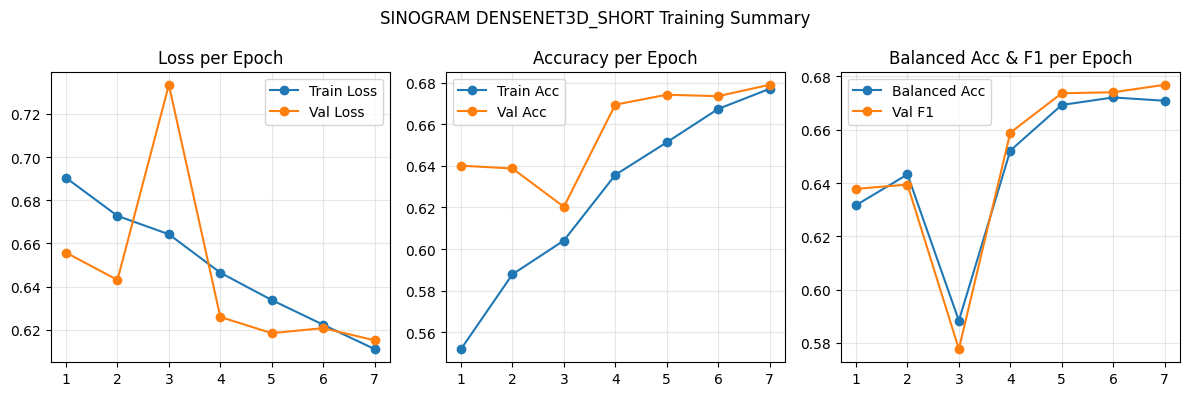


Checking short-run status: EFFICIENTNET3D
EFFICIENTNET3D has 0 epochs logged. Continuing for 7 more.
No checkpoint found, starting fresh.
 Class counts: [3779, 3066]

Training SINOGRAM model (efficientnet3d_short) on CUDA for 7 epochs...



Epoch 1/7: 100%|██████████| 3423/3423 [27:26<00:00,  2.08it/s, train_loss=1.239, train_acc=0.514]


 Epoch 1/7 | Train Loss 1.0733, Acc 0.514 | Val Loss 0.7880, Acc 0.618, BalAcc 0.596, F1 0.599
New best model saved: checkpoints/sinogram_efficientnet3d_short_best.pt (val_acc=0.6176)


Epoch 2/7: 100%|██████████| 3423/3423 [27:51<00:00,  2.05it/s, train_loss=0.763, train_acc=0.531]


 Epoch 2/7 | Train Loss 0.7947, Acc 0.531 | Val Loss 0.7346, Acc 0.467, BalAcc 0.516, F1 0.327


Epoch 3/7: 100%|██████████| 3423/3423 [24:48<00:00,  2.30it/s, train_loss=0.589, train_acc=0.556]


 Epoch 3/7 | Train Loss 0.7387, Acc 0.556 | Val Loss 0.7121, Acc 0.511, BalAcc 0.553, F1 0.421


Epoch 4/7: 100%|██████████| 3423/3423 [29:41<00:00,  1.92it/s, train_loss=0.503, train_acc=0.567]


 Epoch 4/7 | Train Loss 0.7186, Acc 0.567 | Val Loss 0.6394, Acc 0.656, BalAcc 0.645, F1 0.652
New best model saved: checkpoints/sinogram_efficientnet3d_short_best.pt (val_acc=0.6564)


Epoch 5/7: 100%|██████████| 3423/3423 [30:16<00:00,  1.88it/s, train_loss=0.660, train_acc=0.603] 


 Epoch 5/7 | Train Loss 0.6869, Acc 0.603 | Val Loss 0.6280, Acc 0.662, BalAcc 0.652, F1 0.658
New best model saved: checkpoints/sinogram_efficientnet3d_short_best.pt (val_acc=0.6619)


Epoch 6/7: 100%|██████████| 3423/3423 [24:56<00:00,  2.29it/s, train_loss=0.193, train_acc=0.639]


 Epoch 6/7 | Train Loss 0.6584, Acc 0.639 | Val Loss 0.6364, Acc 0.649, BalAcc 0.655, F1 0.649


Epoch 7/7: 100%|██████████| 3423/3423 [30:30<00:00,  1.87it/s, train_loss=0.419, train_acc=0.660]


 Epoch 7/7 | Train Loss 0.6351, Acc 0.660 | Val Loss 0.6321, Acc 0.652, BalAcc 0.642, F1 0.649

Training complete in 240.26 minutes. Best Val Acc = 0.6619
Saved metrics to results/sinogram_efficientnet3d_short_training_metrics.csv


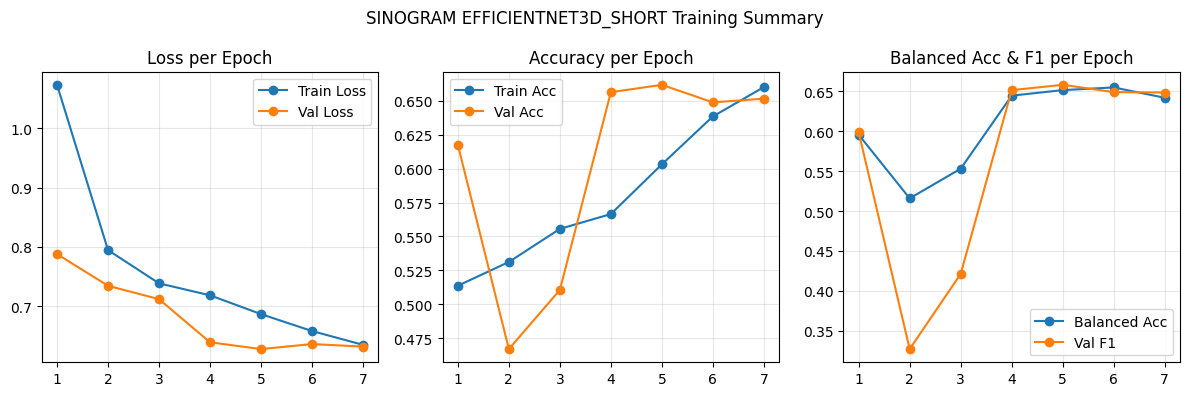


Checking short-run status: MOBILENET3D
MOBILENET3D has 0 epochs logged. Continuing for 7 more.
No checkpoint found, starting fresh.
 Class counts: [3779, 3066]

Training SINOGRAM model (mobilenet3d_short) on CUDA for 7 epochs...



Epoch 1/7: 100%|██████████| 3423/3423 [2:11:56<00:00,  2.31s/it, train_loss=0.735, train_acc=0.562]  


 Epoch 1/7 | Train Loss 0.6865, Acc 0.562 | Val Loss 0.6607, Acc 0.605, BalAcc 0.584, F1 0.587
New best model saved: checkpoints/sinogram_mobilenet3d_short_best.pt (val_acc=0.6053)


Epoch 2/7: 100%|██████████| 3423/3423 [2:11:44<00:00,  2.31s/it, train_loss=0.778, train_acc=0.578]  


 Epoch 2/7 | Train Loss 0.6776, Acc 0.578 | Val Loss 0.6646, Acc 0.611, BalAcc 0.583, F1 0.580
New best model saved: checkpoints/sinogram_mobilenet3d_short_best.pt (val_acc=0.6108)


Epoch 3/7: 100%|██████████| 3423/3423 [2:11:40<00:00,  2.31s/it, train_loss=0.805, train_acc=0.585]  


 Epoch 3/7 | Train Loss 0.6716, Acc 0.585 | Val Loss 0.6492, Acc 0.648, BalAcc 0.631, F1 0.637
New best model saved: checkpoints/sinogram_mobilenet3d_short_best.pt (val_acc=0.6476)


Epoch 4/7: 100%|██████████| 3423/3423 [2:11:39<00:00,  2.31s/it, train_loss=0.603, train_acc=0.622]  


 Epoch 4/7 | Train Loss 0.6562, Acc 0.622 | Val Loss 0.6513, Acc 0.643, BalAcc 0.638, F1 0.643


Epoch 5/7: 100%|██████████| 3423/3423 [2:11:39<00:00,  2.31s/it, train_loss=0.424, train_acc=0.637]  


 Epoch 5/7 | Train Loss 0.6441, Acc 0.637 | Val Loss 0.6374, Acc 0.663, BalAcc 0.659, F1 0.663
New best model saved: checkpoints/sinogram_mobilenet3d_short_best.pt (val_acc=0.6633)


Epoch 6/7: 100%|██████████| 3423/3423 [2:14:37<00:00,  2.36s/it, train_loss=1.112, train_acc=0.644]  


 Epoch 6/7 | Train Loss 0.6351, Acc 0.644 | Val Loss 0.6408, Acc 0.637, BalAcc 0.647, F1 0.636


Epoch 7/7: 100%|██████████| 3423/3423 [2:23:58<00:00,  2.52s/it, train_loss=0.260, train_acc=0.657]  


 Epoch 7/7 | Train Loss 0.6240, Acc 0.657 | Val Loss 0.6285, Acc 0.663, BalAcc 0.659, F1 0.663

Training complete in 982.19 minutes. Best Val Acc = 0.6633
Saved metrics to results/sinogram_mobilenet3d_short_training_metrics.csv


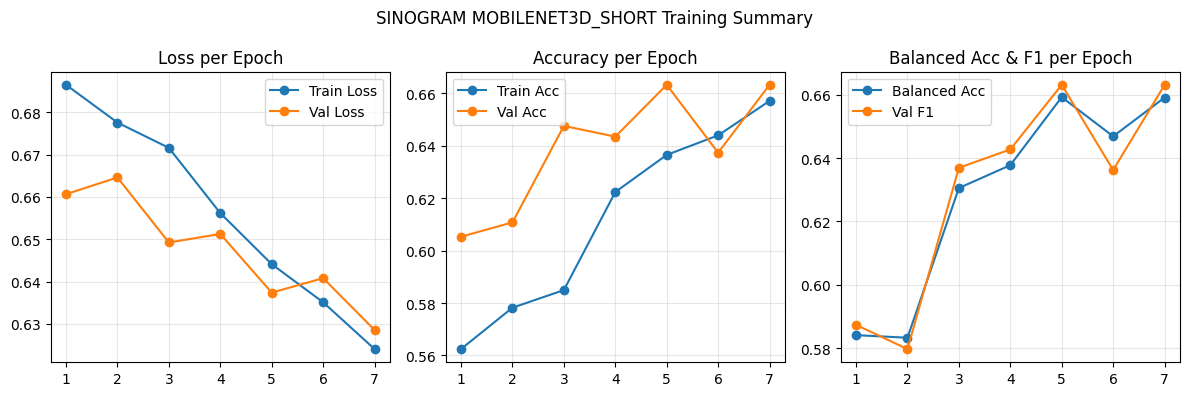


Short-run resumed summary saved to results/early_ranking.csv


Model  LastValACC  PredAinf     Slope
1      densenet3d    0.678937  1.000000  0.014656
0        resnet3d    0.664622  1.000000  0.007328
3     mobilenet3d    0.663258  0.661202  0.003920
2  efficientnet3d    0.651670  0.600509  0.035276

In [43]:
early_results, fit_data = [], {}

for name, model in model_configs.items():
    print(f"\nChecking short-run status: {name.upper()}")
    
    metrics_csv = f"results/sinogram_{name}_short_training_metrics.csv"
    ckpt_short = f"checkpoints/sinogram_{name}_short.pt"

    # --- Detect if this model already has training history ---
    if os.path.exists(metrics_csv):
        df_hist = pd.read_csv(metrics_csv)
        n_epochs_done = len(df_hist)
    else:
        n_epochs_done = 0

    # --- Skip if it already reached 7 epochs ---
    if n_epochs_done >= 7:
        print(f"{name.upper()} already completed 7 epochs — skipping retrain.")
        val_acc = df_hist["val_acc"].values
        epochs = np.arange(1, len(val_acc)+1)
    else:
        # --- Resume or start training ---
        remaining_epochs = 7 - n_epochs_done
        print(f"{name.upper()} has {n_epochs_done} epochs logged. Continuing for {remaining_epochs} more.")

        # Rebuild model
        if name == "resnet3d_18": model = resnet18_3d(2)
        elif name == "resnet3d_34": model = resnet34_3d(2)
        elif name == "densenet3d": model = densenet3d(2)
        elif name == "efficientnet3d": model = efficientnet3d(2)
        elif name == "mobilenet3d": model = mobilenet3d(2)

        # Load checkpoint if it exists
        if os.path.exists(ckpt_short):
            print(f"Resuming from checkpoint: {ckpt_short}")
            model.load_state_dict(torch.load(ckpt_short))
        else:
            print(f"No checkpoint found, starting fresh.")

        # Continue training
        _, hist = train_model(
            model, train_sino, val_sino,
            num_epochs=remaining_epochs,
            model_name=f"{name}_short",
            data_type="sinogram"
        )

        # Reload the completed CSV (which now includes resumed epochs)
        df_hist = pd.read_csv(metrics_csv)
        val_acc = df_hist["val_acc"].values
        epochs = np.arange(1, len(val_acc)+1)

    # --- Fit exponential learning curve ---
    try:
        popt, _ = curve_fit(
            lambda e, A_inf, A0, k: A_inf - (A_inf - A0) * np.exp(-k * e),
            epochs, val_acc, bounds=([0,0,0],[1,1,5]), maxfev=8000
        )
    except Exception as e:
        print(f"Curve fit failed for {name}: {e}")
        popt = [np.nan, np.nan, np.nan]

    early_results.append({
        "Model": name,
        "LastValACC": val_acc[-1],
        "PredAinf": popt[0],
        "Slope": np.mean(np.diff(val_acc[-5:])) if len(val_acc) >= 5 else np.nan
    })
    fit_data[name] = (epochs, val_acc, popt)

# --- Save early summary ---
df_early = pd.DataFrame(early_results).sort_values("PredAinf", ascending=False)
df_early.to_csv("results/early_ranking.csv", index=False)
print("\nShort-run resumed summary saved to results/early_ranking.csv")
display(df_early)


In [47]:
df_early = pd.DataFrame(early_results).sort_values("PredAinf", ascending=False)
df_early.to_csv("results/early_ranking.csv", index=False)
print("\nEarly ranking:\n", df_early.head(4))


Early ranking:
             Model  LastValACC  PredAinf     Slope
1      densenet3d    0.678937  1.000000  0.014656
0        resnet3d    0.664622  1.000000  0.007328
3     mobilenet3d    0.663258  0.661202  0.003920
2  efficientnet3d    0.651670  0.600509  0.035276


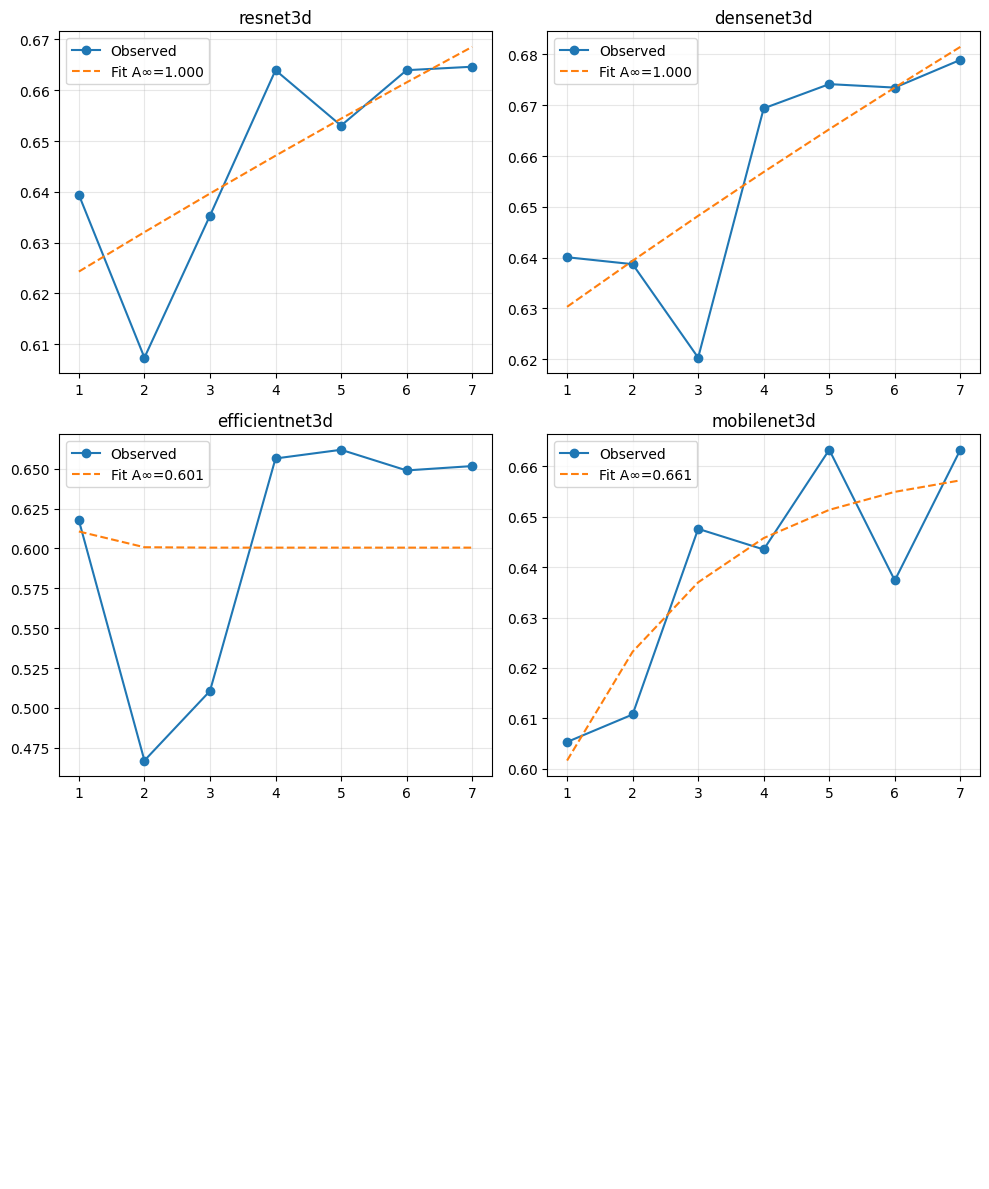

Top models for full training: ['densenet3d', 'resnet3d']


In [45]:
fig, axs = plt.subplots(3,2, figsize=(10,12))
axs = axs.ravel()
for i,(name,(ep,acc,popt)) in enumerate(fit_data.items()):
    axs[i].plot(ep, acc, "o-", label="Observed")
    if not np.isnan(popt[0]):
        axs[i].plot(ep, exp_curve(ep,*popt), "--", label=f"Fit A∞={popt[0]:.3f}")
    axs[i].set_title(name); axs[i].legend(); axs[i].grid(alpha=.3)
for j in range(i+1,len(axs)): axs[j].axis("off")
plt.tight_layout(); plt.savefig("results/early_learning_curves.png",dpi=300); plt.show()

top_models = df_early.head(2)["Model"].tolist()
print(f"Top models for full training: {top_models}")

In [ ]:
ckpt_dir = "checkpoints"
results_dir = "results"

summary = []
for m in models:
    files = {
        "short": f"sinogram_{m}_short_best.pt",
        "full":  f"sinogram_{m}_best.pt"
    }
    metrics = {
        "short": f"sinogram_{m}_short_training_metrics.csv",
        "full":  f"sinogram_{m}_training_metrics.csv"
    }
    row = {"Model": m}
    for phase in ["short", "full"]:
        ckpt = os.path.join(ckpt_dir, files[phase])
        csv  = os.path.join(results_dir, metrics[phase])
        if os.path.exists(ckpt):
            row[f"{phase}_time"] = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(os.path.getmtime(ckpt)))
            row[f"{phase}_sizeMB"] = round(os.path.getsize(ckpt)/1e6, 1)
        if os.path.exists(csv):
            row[f"{phase}_bestValAcc"] = pd.read_csv(csv)["val_acc"].max()
    summary.append(row)

pd.DataFrame(summary).sort_values("Model")


Continuing training: DENSENET3D
Resuming from checkpoints/sinogram_densenet3d_short_best.pt
 Class counts: [3779, 3066]
Found existing checkpoint: checkpoints/sinogram_densenet3d_best.pt
Resuming densenet3d with previous best val_acc=0.6783 (full run)
Resuming densenet3d with previous best val_acc=0.6789 (short run)

Training SINOGRAM model (densenet3d) on CUDA for 13 epochs...



Epoch 1/13: 100%|██████████| 3423/3423 [32:10<00:00,  1.77it/s, train_loss=0.538, train_acc=0.640]


 Epoch 1/13 | Train Loss 0.6405, Acc 0.640 | Val Loss 0.6239, Acc 0.664, BalAcc 0.657, F1 0.663


Epoch 2/13: 100%|██████████| 3423/3423 [33:19<00:00,  1.71it/s, train_loss=0.993, train_acc=0.647]


 Epoch 2/13 | Train Loss 0.6383, Acc 0.647 | Val Loss 0.6257, Acc 0.664, BalAcc 0.659, F1 0.664


Epoch 3/13: 100%|██████████| 3423/3423 [26:35<00:00,  2.15it/s, train_loss=0.957, train_acc=0.652] 


 Epoch 3/13 | Train Loss 0.6299, Acc 0.652 | Val Loss 0.6221, Acc 0.671, BalAcc 0.655, F1 0.662


Epoch 4/13: 100%|██████████| 3423/3423 [37:12<00:00,  1.53it/s, train_loss=1.057, train_acc=0.659] 


 Epoch 4/13 | Train Loss 0.6276, Acc 0.659 | Val Loss 0.6149, Acc 0.680, BalAcc 0.665, F1 0.672
New best model saved: checkpoints/sinogram_densenet3d_best.pt (val_acc=0.6803)


Epoch 5/13: 100%|██████████| 3423/3423 [29:56<00:00,  1.91it/s, train_loss=0.284, train_acc=0.669]  


 Epoch 5/13 | Train Loss 0.6192, Acc 0.669 | Val Loss 0.6569, Acc 0.643, BalAcc 0.657, F1 0.638


Epoch 6/13: 100%|██████████| 3423/3423 [26:17<00:00,  2.17it/s, train_loss=0.751, train_acc=0.670]


 Epoch 6/13 | Train Loss 0.6129, Acc 0.670 | Val Loss 0.6121, Acc 0.675, BalAcc 0.662, F1 0.669


Epoch 7/13: 100%|██████████| 3423/3423 [37:47<00:00,  1.51it/s, train_loss=0.252, train_acc=0.685]  


 Epoch 7/13 | Train Loss 0.6003, Acc 0.685 | Val Loss 0.6385, Acc 0.667, BalAcc 0.674, F1 0.668


Epoch 8/13: 100%|██████████| 3423/3423 [38:24<00:00,  1.49it/s, train_loss=0.351, train_acc=0.689] 


 Epoch 8/13 | Train Loss 0.5933, Acc 0.689 | Val Loss 0.6106, Acc 0.678, BalAcc 0.667, F1 0.674


Epoch 9/13: 100%|██████████| 3423/3423 [31:39<00:00,  1.80it/s, train_loss=0.334, train_acc=0.704]  


 Epoch 9/13 | Train Loss 0.5803, Acc 0.704 | Val Loss 0.6225, Acc 0.663, BalAcc 0.671, F1 0.662
Early stopping triggered after 9 epochs.

Training complete in 361.30 minutes. Best Val Acc = 0.6803
Saved metrics to results/sinogram_densenet3d_training_metrics.csv


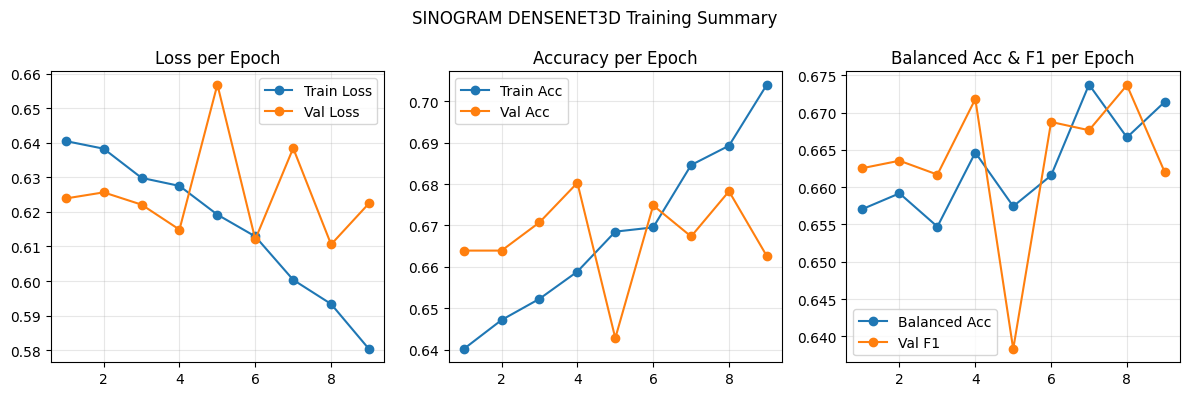

densenet3d | Best validation ACC = 0.680

Continuing training: RESNET3D
Resuming from checkpoints/sinogram_resnet3d_short_best.pt
 Class counts: [3779, 3066]
Found existing checkpoint: checkpoints/sinogram_resnet3d_best.pt
Resuming resnet3d with previous best val_acc=0.6633 (full run)
Resuming resnet3d with previous best val_acc=0.6646 (short run)

Training SINOGRAM model (resnet3d) on CUDA for 13 epochs...



Epoch 1/13: 100%|██████████| 3423/3423 [29:28<00:00,  1.94it/s, train_loss=0.317, train_acc=0.635] 


 Epoch 1/13 | Train Loss 0.6479, Acc 0.635 | Val Loss 0.9377, Acc 0.558, BalAcc 0.508, F1 0.413


Epoch 2/13: 100%|██████████| 3423/3423 [37:27<00:00,  1.52it/s, train_loss=0.939, train_acc=0.633] 


 Epoch 2/13 | Train Loss 0.6480, Acc 0.633 | Val Loss 0.7593, Acc 0.552, BalAcc 0.500, F1 0.393


Epoch 3/13: 100%|██████████| 3423/3423 [31:04<00:00,  1.84it/s, train_loss=0.389, train_acc=0.641] 


 Epoch 3/13 | Train Loss 0.6415, Acc 0.641 | Val Loss 0.6342, Acc 0.662, BalAcc 0.656, F1 0.661


Epoch 4/13: 100%|██████████| 3423/3423 [38:45<00:00,  1.47it/s, train_loss=0.576, train_acc=0.649] 


 Epoch 4/13 | Train Loss 0.6353, Acc 0.649 | Val Loss 0.6680, Acc 0.613, BalAcc 0.632, F1 0.604


Epoch 5/13:   4%|▎         | 122/3423 [01:42<32:54,  1.67it/s, train_loss=0.503, train_acc=0.656] 

In [ ]:
val_acc_records = {}

for name in top_models:
    print(f"\nContinuing training: {name.upper()}")

    # --- Rebuild model architecture ---
    if name == "resnet3d": model = resnet3d(2)
    elif name == "densenet3d": model = densenet3d(2)
    elif name == "efficientnet3d": model = efficientnet3d(2)
    elif name == "mobilenet3d": model = mobilenet3d(2)
    else:
        print(f"Unknown model name: {name}")
        continue

    # --- Try to load the 7-epoch checkpoint ---
    ckpt_short = f"checkpoints/sinogram_{name}_short_best.pt"
    if os.path.exists(ckpt_short):
        print(f"Resuming from {ckpt_short}")
        model.load_state_dict(torch.load(ckpt_short))
    else:
        print(f"No short-run checkpoint found for {name}, training from scratch")

    # --- Continue training for remaining epochs (e.g., 13 more to reach 20 total) ---
    _, hist = train_model(
        model=model,
        train_dataset=train_sino,
        val_dataset=val_sino,
        num_epochs=13,      # remaining epochs
        model_name=name,    # full model name (will save to sinogram_{name}.pt)
        data_type="sinogram"
    )

    best_acc = max(hist.get("val_acc", [0]))
    val_acc_records[name] = best_acc
    print(f"{name} | Best validation ACC = {best_acc:.3f}")

In [ ]:
best_model_name = max(val_acc_records, key=val_acc_records.get)
print(f"\nTrue best model based on validation ACC: {best_model_name}")

ckpt = f"checkpoints/sinogram_{best_model_name}.pt"
print(f"Loading best checkpoint: {ckpt}")

# --- Rebuild final best model ---
if best_model_name == "resnet3d_18": best_model_sino = resnet18_3d(2)
elif best_model_name == "resnet3d_34": best_model_sino = resnet34_3d(2)
elif best_model_name == "densenet3d": best_model_sino = densenet3d(2)
elif best_model_name == "efficientnet3d": best_model_sino = efficientnet3d(2)
elif best_model_name == "mobilenet3d": best_model_sino = mobilenet3d(2)
else:
    raise ValueError(f"Unknown model: {best_model_name}")

# --- Load trained weights and prepare for evaluation ---
best_model_sino.load_state_dict(torch.load(ckpt))
best_model_sino.to("cuda").eval()

In [ ]:
acc_sino_uncal, f1_sino_uncal, auc_sino_uncal, cm_sino_uncal, best_thr_sino_uncal = evaluate_model(best_model_sino, test_loader_sino, calibrator=None)

In [ ]:
best_acc_sino_test, best_f1_sino_test, best_auc_sino_test, best_cm_sino_test, best_thr_sino = evaluate_model(
    best_model_sino,
    test_loader_sino,
    calibrator=None,
    custom_thr=best_thr_sino,
    save_dir="results/sino_best_eval",
    prefix="best_sino_uncal",
    device=device
)

In [ ]:
print("\n--- Training on Sinograms (ResNet3D-18) ---")
model_sino_resnet = resnet3d(num_classes=2)
can = train_model(model_sino_resnet, train_sino, val_sino,
            data_type="sinogram", model_name="resnet3d", num_epochs=20, loss_type="weighted_ce")

In [ ]:
print("\n--- Training on Sinograms (DenseNet3D-18) ---")
model_sino_densenet = densenet3d(num_classes=2)
model_sino_densenet, hist_sino_densenet = train_model(model_sino_densenet, train_sino, val_sino, num_epochs=20,
            data_type="sinogram", model_name="densenet3d", loss_type="weighted_ce")

Evaluation complete in 21.24 minutes
Best threshold: 0.30
Accuracy: 0.6149, F1: 0.6713, ROC AUC: 0.7211

--- Per-class Report ---
Normal    P=0.802, R=0.401, F1=0.535
Abnormal  P=0.543, R=0.878, F1=0.671
Report saved to results/eval_report.json
Predictions saved to results


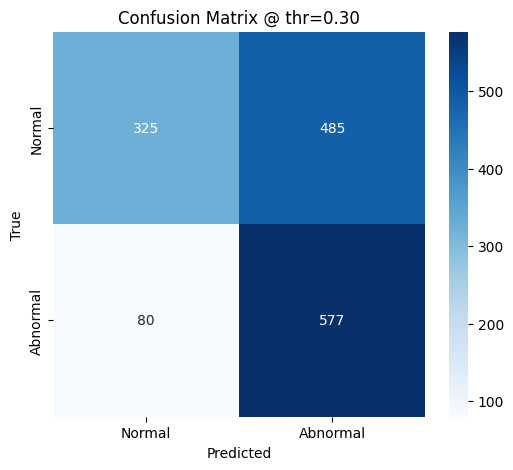

Confusion matrix saved to results/eval_confusion_matrix.png


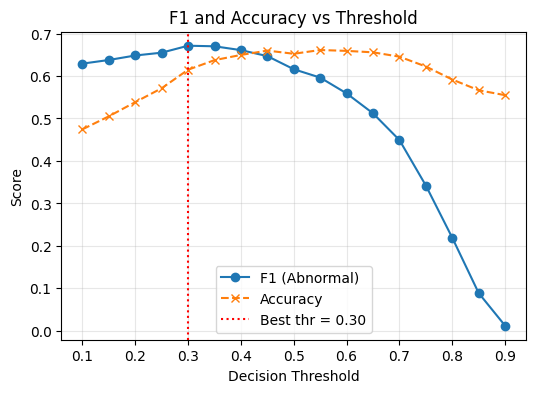

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [213]:
acc_sino_uncal, f1_sino_uncal, auc_sino_uncal, cm_sino_uncal, best_thr_sino_uncal = evaluate_model(model_sino_resnet, test_loader_sino, calibrator=None)

Evaluation complete in 13.76 minutes
Best threshold: 0.30
Accuracy: 0.6149, F1: 0.6713, ROC AUC: 0.7211

--- Per-class Report ---
Normal    P=0.802, R=0.401, F1=0.535
Abnormal  P=0.543, R=0.878, F1=0.671
Report saved to results/sino_eval/resnet/eval_report.json
Predictions saved to results/sino_eval/resnet


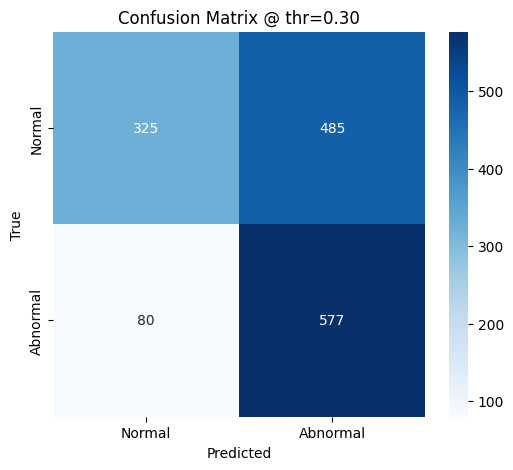

Confusion matrix saved to results/sino_eval/resnet/eval_confusion_matrix.png


In [129]:
acc_sino_uncal, f1_sino_uncal, auc_sino_uncal, cm_sino_uncal, best_thr_sino_uncal = evaluate_model(model_sino_resnet, test_loader_sino, custom_thr=best_thr_sino_uncal, save_dir="results/sino_eval/resnet", calibrator=None)

In [201]:
calibrator_sino = fit_fast_temperature(model_sino_resnet, val_loader_sino, device=device) 

joblib.dump(calibrator_sino, "calibrator.pkl")

[Cal] Starting fast temperature fitting...


  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

[Cal] Early stop @ epoch 7
[Cal] Optimal temperature: 1.174


['calibrator.pkl']

In [202]:
calibrator_sino = joblib.load("calibrator.pkl")

Evaluation complete in 19.95 minutes
Best threshold: 0.35
Accuracy: 0.6299, F1: 0.6747, ROC AUC: 0.7211

--- Per-class Report ---
Normal    P=0.793, R=0.446, F1=0.571
Abnormal  P=0.556, R=0.857, F1=0.675
Report saved to results/eval_report.json
Predictions saved to results


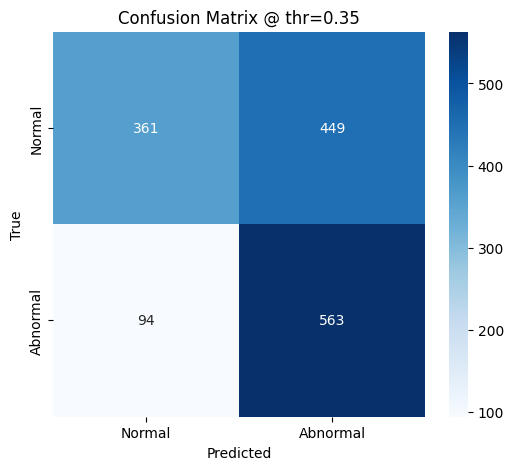

Confusion matrix saved to results/eval_confusion_matrix.png


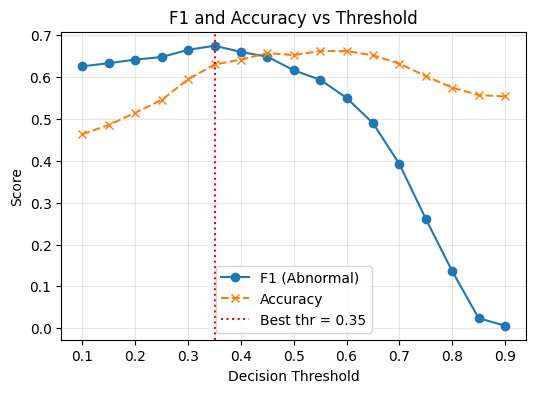

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [227]:
acc_val, f1_val, auc_val, cm_val, best_thr_sino = evaluate_model(
    model_sino_resnet,
    test_loader_sino,
    calibrator=calibrator_sino,
    device=device
)

Evaluation complete in 20.54 minutes
Best threshold: 0.40
Accuracy: 0.6414, F1: 0.6598, ROC AUC: 0.7211

--- Per-class Report ---
Normal    P=0.746, R=0.532, F1=0.621
Abnormal  P=0.574, R=0.776, F1=0.660
Report saved to results/sino_eval/resnet/eval_report.json
Predictions saved to results/sino_eval/resnet


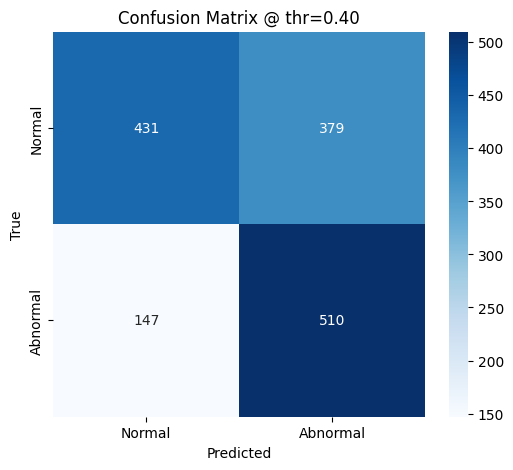

Confusion matrix saved to results/sino_eval/resnet/eval_confusion_matrix.png


In [204]:
acc_sino, f1_sino, auc_sino, cm_sino, best_thr_sino = evaluate_model(
    model_sino_resnet,
    test_loader_sino,
    calibrator=calibrator_sino,
    custom_thr=best_thr_sino,
    save_dir="results/sino_eval/resnet",
    device=device
)

Evaluation complete in 17.53 minutes
Best threshold: 0.20
Accuracy: 0.6040, F1: 0.6624, ROC AUC: 0.7272

--- Per-class Report ---
Normal    P=0.784, R=0.390, F1=0.521
Abnormal  P=0.536, R=0.868, F1=0.662
Report saved to results/eval_report.json
Predictions saved to results


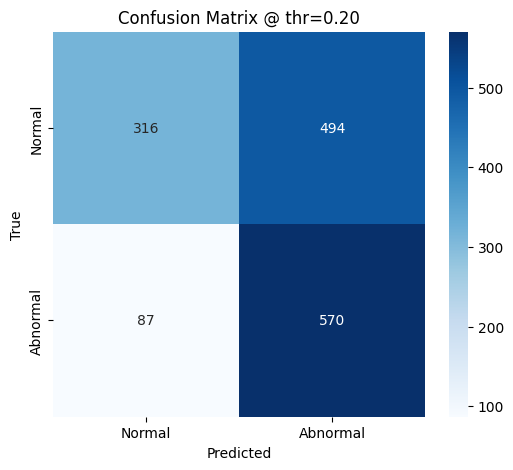

Confusion matrix saved to results/eval_confusion_matrix.png


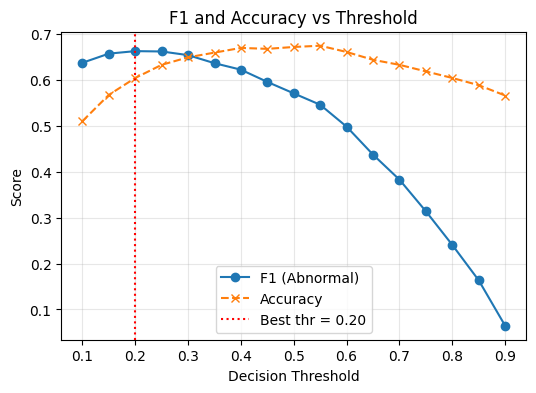

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [187]:
acc_sino_uncaldensenet, f1_sino_uncaldensenet, auc_sino_uncaldensenet, cm_sino_uncaldensenet, best_thr_sinodensenet = evaluate_model(model_sino_densenet, test_loader_sino, calibrator=None)

Evaluation complete in 19.62 minutes
Best threshold: 0.20
Accuracy: 0.6040, F1: 0.6624, ROC AUC: 0.7272

--- Per-class Report ---
Normal    P=0.784, R=0.390, F1=0.521
Abnormal  P=0.536, R=0.868, F1=0.662
Report saved to results/sino_eval/densenet/eval_report.json
Predictions saved to results/sino_eval/densenet


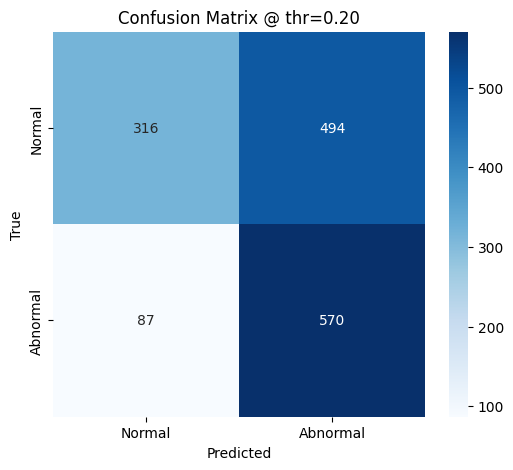

Confusion matrix saved to results/sino_eval/densenet/eval_confusion_matrix.png


In [244]:
acc_sino_uncaldensenet, f1_sino_uncaldensenet, auc_sino_uncaldensenet, cm_sino_uncaldensenet, best_thr_sinodensenet = evaluate_model(model_sino_densenet, test_loader_sino, custom_thr=best_thr_sinodensenet, save_dir="results/sino_eval/densenet", calibrator=None)

In [ ]:
calibrator_sino = fit_fast_temperature(model_sino_resnet, val_loader_sino, device=device) 

joblib.dump(calibrator_sino, "calibrator.pkl")

In [119]:
calibrator_sino = joblib.load("calibrator.pkl")

Evaluation complete in 13.09 minutes
Best threshold: 0.35
Accuracy: 0.6026, F1: 0.6624, ROC AUC: 0.7161

--- Per-class Report ---
Normal    P=0.786, R=0.385, F1=0.517
Abnormal  P=0.535, R=0.871, F1=0.662
Report saved to results/eval_report.json
Predictions saved to results


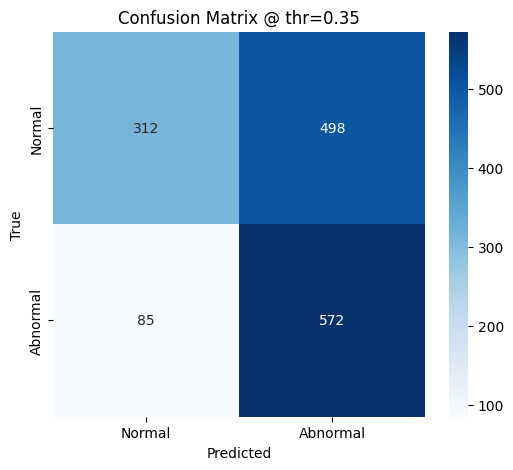

Confusion matrix saved to results/eval_confusion_matrix.png


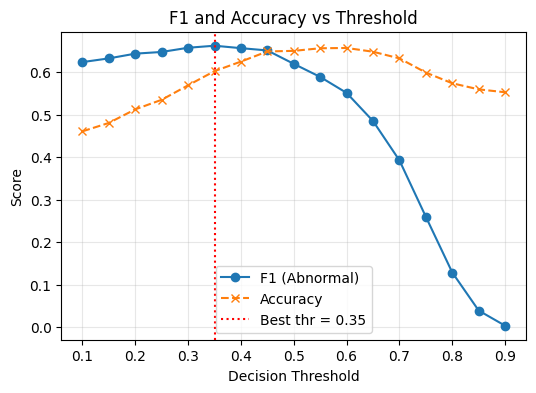

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [120]:
acc_val, f1_val, auc_val, cm_val, best_thr_sino = evaluate_model(
    model_sino_resnet,
    test_loader_sino,
    calibrator=calibrator_sino,
    device=device
)

Evaluation complete in 14.62 minutes
Best threshold: 0.35
Accuracy: 0.6012, F1: 0.6520, ROC AUC: 0.7231

--- Per-class Report ---
Normal    P=0.754, R=0.412, F1=0.533
Abnormal  P=0.535, R=0.834, F1=0.652
Report saved to results/sino_eval/sino_test_report.json
Predictions saved to results/sino_eval


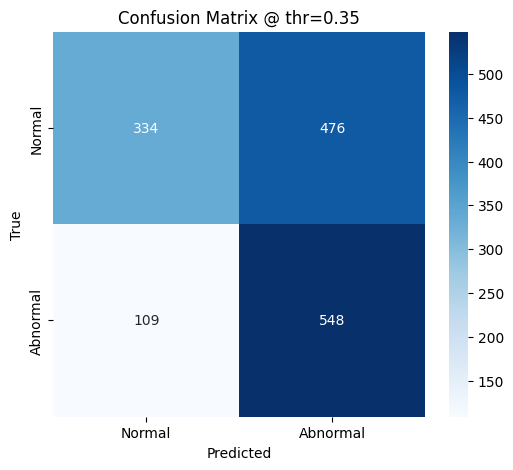

Confusion matrix saved to results/sino_eval/sino_test_confusion_matrix.png


In [121]:
acc_sino, f1_sino, auc_sino, cm_sino, best_thr_sino = evaluate_model(
    model_sino_resnet,
    test_loader_sino,
    calibrator=calibrator_sino,
    custom_thr=best_thr_sino,
    save_dir="results/sino_eval",
    prefix="sino_test",
    device=device
)

Evaluation complete in 15.07 minutes
Best threshold: 0.35
Accuracy: 0.6251, F1: 0.6506, ROC AUC: 0.7231

--- Per-class Report ---
Normal    P=0.736, R=0.500, F1=0.596
Abnormal  P=0.558, R=0.779, F1=0.651
Report saved to results/sino_eval/sino_uncal_report.json
Predictions saved to results/sino_eval


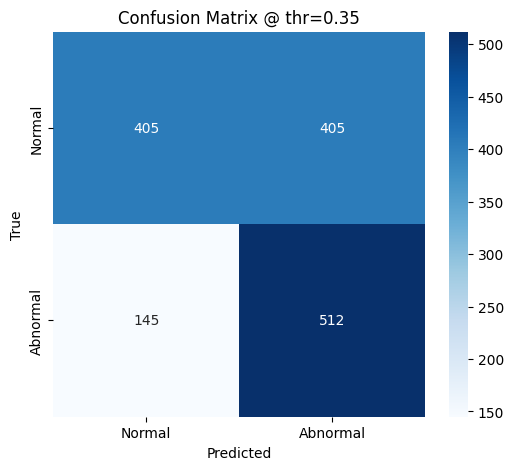

Confusion matrix saved to results/sino_eval/sino_uncal_confusion_matrix.png


In [122]:
acc_test, f1_test, auc_test, cm_test, best_thr_sino = evaluate_model(
    model_sino_resnet,
    test_loader_sino,
    calibrator=None,
    custom_thr=best_thr_sino,
    save_dir="results/sino_eval",
    prefix="sino_uncal",
    device=device
)

In [ ]:
# Volume model with ResNet-18 (3D)
print("\n--- Training on Volumes (ResNet3D-18) ---")
model_vol_resnet = resnet3d(num_classes=2)

model_vol_resnet, hist_vol_resnet = train_model(model_vol_resnet, train_vol, val_vol,
            data_type="volume", model_name="resnet3d", num_epochs=20, loss_type="weighted_ce")

Evaluation complete in 9.50 minutes
Best threshold: 0.35
Accuracy: 0.6271, F1: 0.6543, ROC AUC: 0.7255

--- Per-class Report ---
Normal    P=0.780, R=0.481, F1=0.595
Abnormal  P=0.544, R=0.821, F1=0.654
Report saved to results/eval_report.json
Predictions saved to results


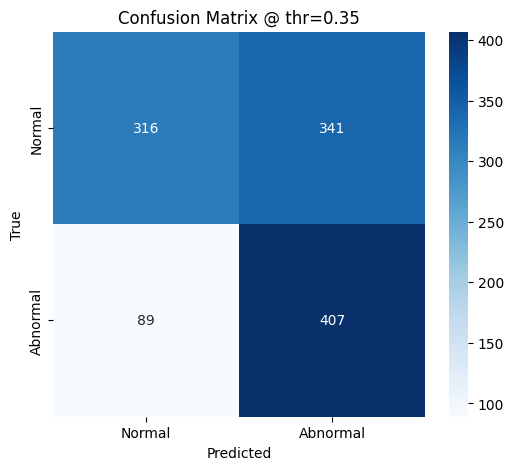

Confusion matrix saved to results/eval_confusion_matrix.png


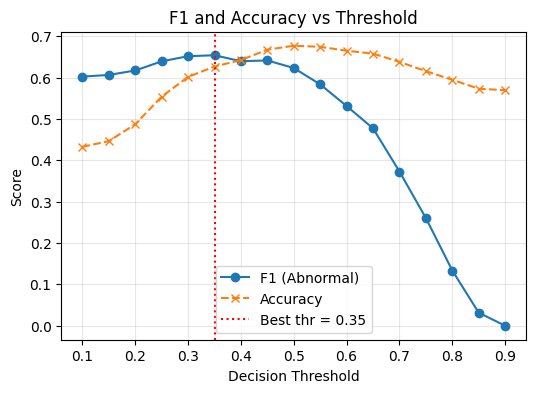

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [215]:
acc_vol_uncalresnet, f1_vol_uncalresnet, auc_vol_uncalresnet, cm_vol_uncalresnet, best_thr_volresnet = evaluate_model(model_vol_resnet, test_loader_vol, calibrator=None)

Evaluation complete in 6.14 minutes
Best threshold: 0.35
Accuracy: 0.6271, F1: 0.6543, ROC AUC: 0.7255

--- Per-class Report ---
Normal    P=0.780, R=0.481, F1=0.595
Abnormal  P=0.544, R=0.821, F1=0.654
Report saved to results/vol_eval/resnet/eval_report.json
Predictions saved to results/vol_eval/resnet


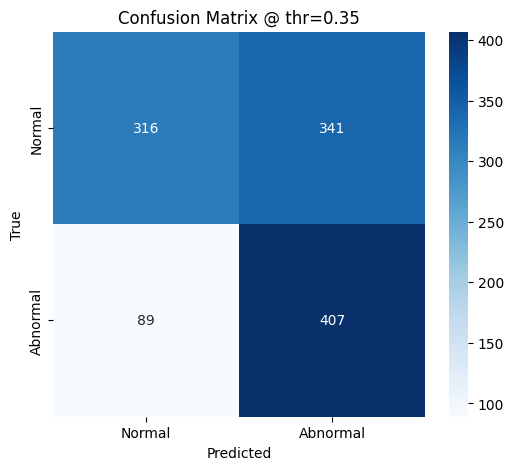

Confusion matrix saved to results/vol_eval/resnet/eval_confusion_matrix.png


In [216]:
acc_vol_uncalresnet, f1_vol_uncalresnet, auc_vol_uncalresnet, cm_vol_uncalresnet, best_thr_volresnet = evaluate_model(model_vol_resnet, test_loader_vol, custom_thr=best_thr_volresnet, save_dir="results/vol_eval/resnet", calibrator=None)

In [ ]:
calibrator_vol = fit_fast_temperature(model_vol_resnet, val_loader_vol, device=device)
joblib.dump(calibrator_vol, "calibrator2.pkl") 

Evaluation complete in 8.49 minutes
Best threshold: 0.35
Accuracy: 0.6297, F1: 0.6531, ROC AUC: 0.7255

--- Per-class Report ---
Normal    P=0.775, R=0.493, F1=0.603
Abnormal  P=0.547, R=0.810, F1=0.653
Report saved to results/eval_report.json
Predictions saved to results


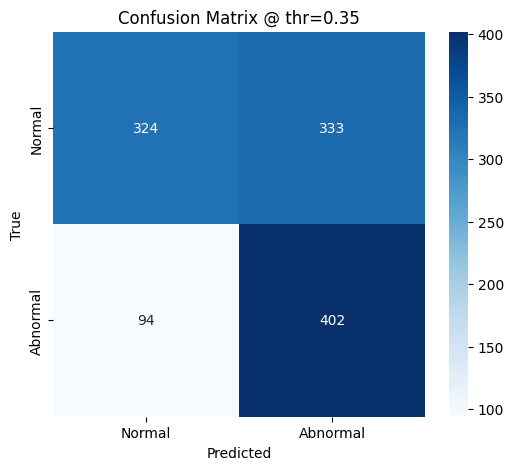

Confusion matrix saved to results/eval_confusion_matrix.png


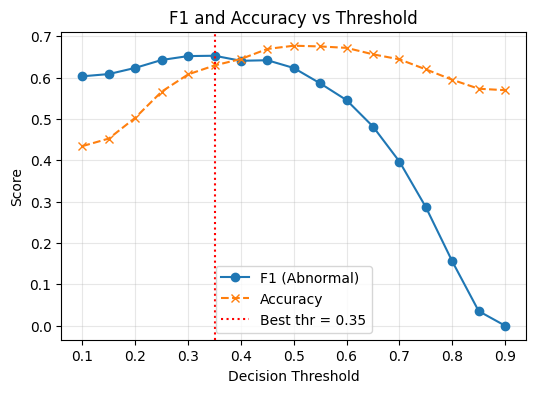

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [245]:
acc_val_vol, f1_val_vol, auc_val_vol, cm_val_vol, best_thr_vol = evaluate_model(
    model_vol_resnet,
    test_loader_vol,
    calibrator=calibrator_vol,
    device=device
)

Evaluation complete in 9.59 minutes
Best threshold: 0.30
Accuracy: 0.6080, F1: 0.6523, ROC AUC: 0.7255

--- Per-class Report ---
Normal    P=0.794, R=0.422, F1=0.551
Abnormal  P=0.527, R=0.855, F1=0.652
Report saved to results/vol_eval/resnet/eval_report.json
Predictions saved to results/vol_eval/resnet


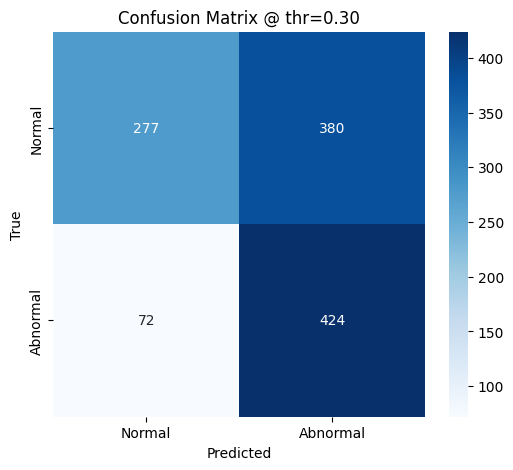

Confusion matrix saved to results/vol_eval/resnet/eval_confusion_matrix.png


In [200]:
acc_vol, f1_vol, auc_vol, cm_vol, best_thr_vol = evaluate_model(
    model_vol_resnet,
    test_loader_vol,
    calibrator=calibrator_vol,
    custom_thr=best_thr_vol, 
    save_dir="results/vol_eval/resnet",
    device=device
)

In [ ]:
# Volume model with DenseNet (3D)
print("\n--- Training on Volumes (Densenet3D) ---")
model_vol_densenet = densenet(num_classes=2)

model_vol_densenet, hist_vol_resnet = train_model(model_vol_resnet, train_vol, val_vol,
            data_type="volume", model_name="densenet", loss_type="weighted_ce", num_epochs = 20)

Evaluation complete in 9.18 minutes
Best threshold: 0.30
Accuracy: 0.6479, F1: 0.6798, ROC AUC: 0.7478

--- Per-class Report ---
Normal    P=0.829, R=0.481, F1=0.609
Abnormal  P=0.558, R=0.869, F1=0.680
Report saved to results/eval_report.json
Predictions saved to results


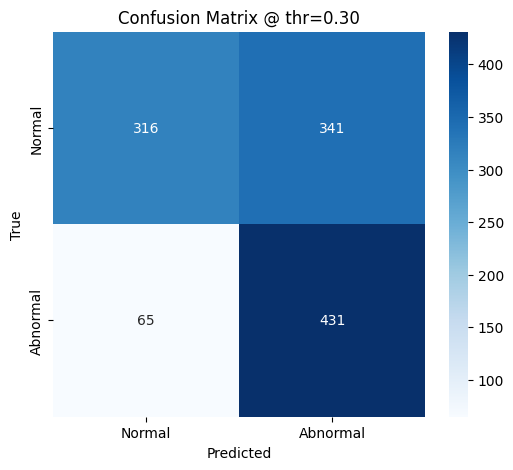

Confusion matrix saved to results/eval_confusion_matrix.png


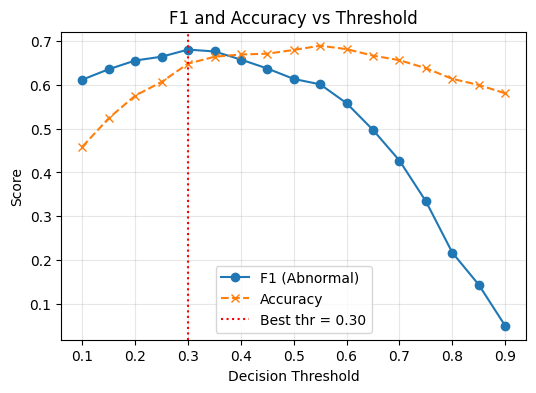

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [123]:
acc_vol_uncaldensenet, f1_vol_uncaldensenet, auc_vol_uncaldensenet, cm_vol_uncaldensenet, best_thr_voldensenet = evaluate_model(model_vol_densenet, test_loader_vol, calibrator=None)

Evaluation complete in 4.54 minutes
Best threshold: 0.30
Accuracy: 0.6479, F1: 0.6798, ROC AUC: 0.7478

--- Per-class Report ---
Normal    P=0.829, R=0.481, F1=0.609
Abnormal  P=0.558, R=0.869, F1=0.680
Report saved to results/vol_eval/densenet/eval_report.json
Predictions saved to results/vol_eval/densenet


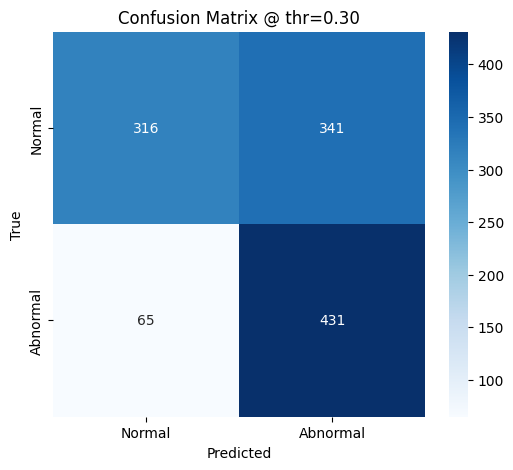

Confusion matrix saved to results/vol_eval/densenet/eval_confusion_matrix.png


In [124]:
acc_vol_uncaldensenet, f1_vol_uncaldensenet, auc_vol_uncaldensenet, cm_vol_uncaldensenet, best_thr_voldensenet = evaluate_model(model_vol_densenet, test_loader_vol, custom_thr=best_thr_voldensenet, save_dir="results/vol_eval/densenet", calibrator=None)

In [ ]:
calibrator_vol = fit_fast_temperature(model_vol_resnet, val_loader_vol, device=device)

In [126]:
joblib.dump(calibrator_vol, "calibrator2.pkl")

['calibrator2.pkl']

Evaluation complete in 4.30 minutes
Best threshold: 0.30
Accuracy: 0.6514, F1: 0.6799, ROC AUC: 0.7514

--- Per-class Report ---
Normal    P=0.819, R=0.495, F1=0.617
Abnormal  P=0.564, R=0.856, F1=0.680
Report saved to results/eval_report.json
Predictions saved to results


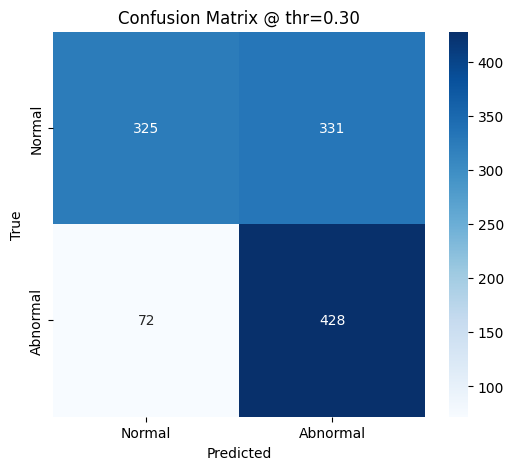

Confusion matrix saved to results/eval_confusion_matrix.png


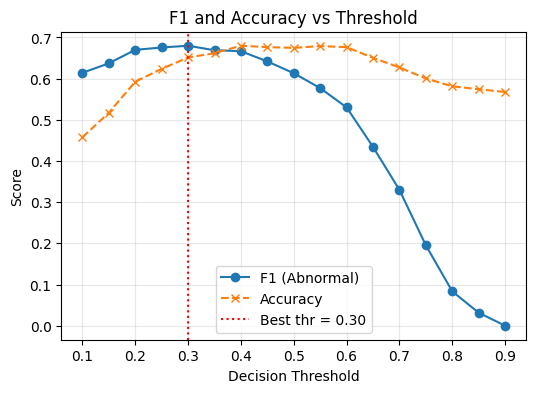

F1-vs-threshold plot saved to results/eval_f1_vs_threshold.png


In [127]:
acc_val_vol, f1_val_vol, auc_val_vol, cm_val_vol, best_thr_vol = evaluate_model(
    model_vol_resnet,
    val_loader_vol,
    calibrator=calibrator_vol,
    device=device
)

Evaluation complete in 9.07 minutes
Best threshold: 0.30
Accuracy: 0.6297, F1: 0.6565, ROC AUC: 0.7365

--- Per-class Report ---
Normal    P=0.783, R=0.484, F1=0.598
Abnormal  P=0.546, R=0.823, F1=0.656
Report saved to results/vol_eval/vol_test_report.json
Predictions saved to results/vol_eval


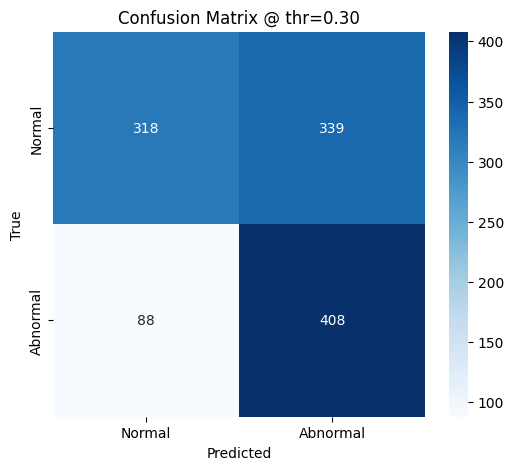

Confusion matrix saved to results/vol_eval/vol_test_confusion_matrix.png


In [128]:
acc_vol, f1_vol, auc_vol, cm_vol, best_thr_vol = evaluate_model(
    model_vol_resnet,
    test_loader_vol,
    calibrator=calibrator_vol,
    custom_thr=best_thr_vol, 
    save_dir="results/vol_eval",
    prefix="vol_test",
    device=device
)

Evaluation complete in 6.41 minutes
Best threshold: 0.30
Accuracy: 0.6445, F1: 0.6787, ROC AUC: 0.7514

--- Per-class Report ---
Normal    P=0.825, R=0.474, F1=0.602
Abnormal  P=0.557, R=0.868, F1=0.679
Report saved to results/vol_eval/vol_uncal_report.json
Predictions saved to results/vol_eval


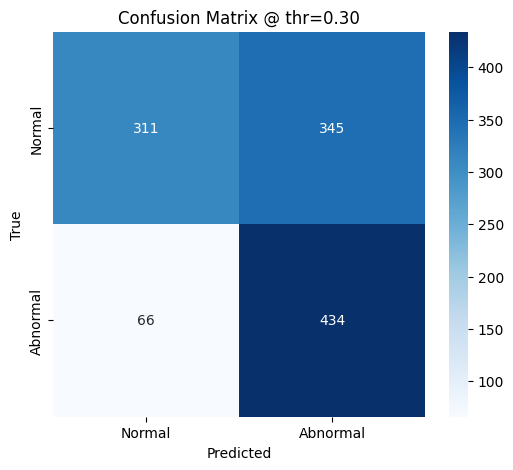

Confusion matrix saved to results/vol_eval/vol_uncal_confusion_matrix.png


In [129]:
acc_test_vol, f1_test_vol, auc_test_vol, cm_test_vol, best_thr_vol = evaluate_model(
    model_vol_resnet,
    test_loader_vol,
    calibrator= None,
    custom_thr=best_thr_vol, 
    save_dir="results/vol_eval",
    prefix="vol_uncal",
    device=device
)

In [217]:
from sklearn.metrics import brier_score_loss
from netcal.metrics import ECE

y_true = np.load("results/sino_eval/resnet/uncal_eval_y_true.npy")
y_prob = np.load("results/sino_eval/resnet/uncal_eval_y_prob.npy")

ece = ECE(bins=15).measure(y_prob, y_true)
brier = brier_score_loss(y_true, y_prob)
print("SINO UNCAL")
print(f"ECE: {ece:.4f}, Brier score: {brier:.4f}")

y_true = np.load("results/sino_eval/resnet/cal_eval_y_true.npy")
y_prob = np.load("results/sino_eval/resnet/cal_eval_y_prob.npy")

ece = ECE(bins=15).measure(y_prob, y_true)
brier = brier_score_loss(y_true, y_prob)
print("SINO CAL")
print(f"ECE: {ece:.4f}, Brier score: {brier:.4f}")

y_true = np.load("results/vol_eval/resnet/uncal_eval_y_true.npy")
y_prob = np.load("results/vol_eval/resnet/uncal_eval_y_prob.npy")

ece = ECE(bins=15).measure(y_prob, y_true)
brier = brier_score_loss(y_true, y_prob)
print("VOL UNCAL")
print(f"ECE: {ece:.4f}, Brier score: {brier:.4f}")

y_true = np.load("results/vol_eval/resnet/cal_eval_y_true.npy")
y_prob = np.load("results/vol_eval/resnet/cal_eval_y_prob.npy")

ece = ECE(bins=15).measure(y_prob, y_true)
brier = brier_score_loss(y_true, y_prob)
print("VOL CAL")
print(f"ECE: {ece:.4f}, Brier score: {brier:.4f}")

SINO UNCAL
ECE: 0.0468, Brier score: 0.2130
SINO CAL
ECE: 0.0467, Brier score: 0.2119
VOL UNCAL
ECE: 0.0419, Brier score: 0.2093
VOL CAL
ECE: 0.0382, Brier score: 0.2094


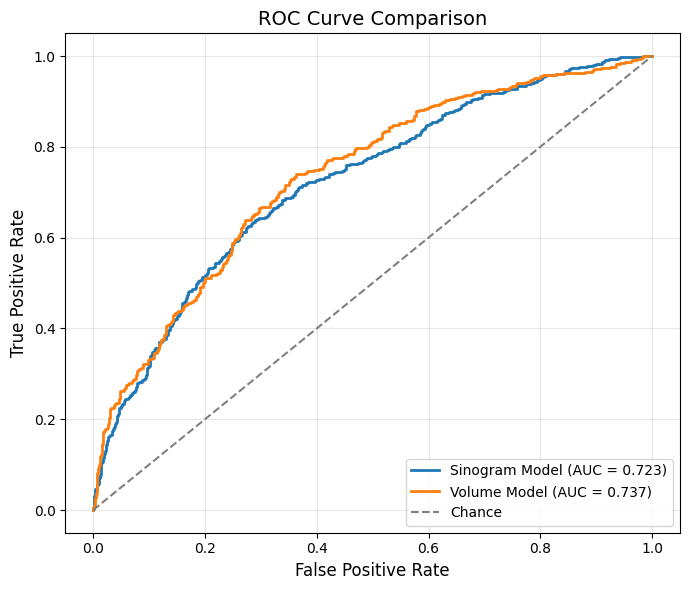

ROC comparison saved to results/roc_sino_vs_vol.png


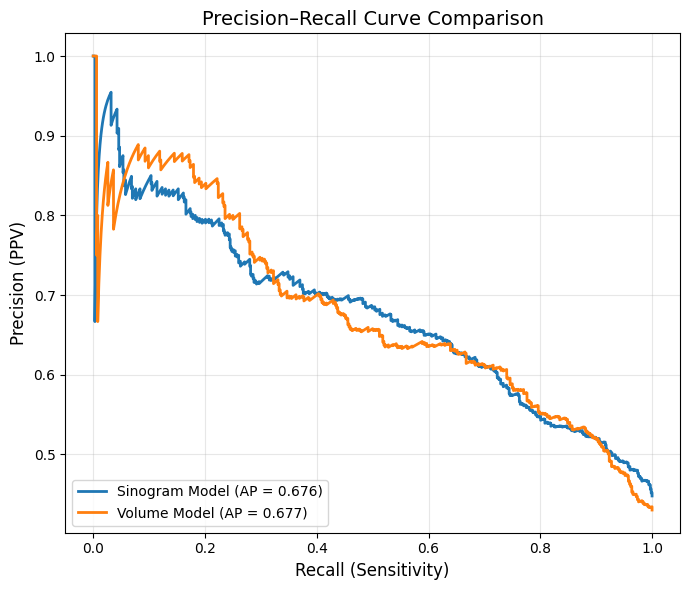

Precision–Recall comparison saved to results/pr_sino_vs_vol.png


In [132]:
compare_curves(
    results_dirs=["results/sino_eval", "results/vol_eval"],
    labels=["Sinogram Model", "Volume Model"],
    save_path_roc="results/roc_sino_vs_vol.png",
    save_path_pr="results/pr_sino_vs_vol.png"
)

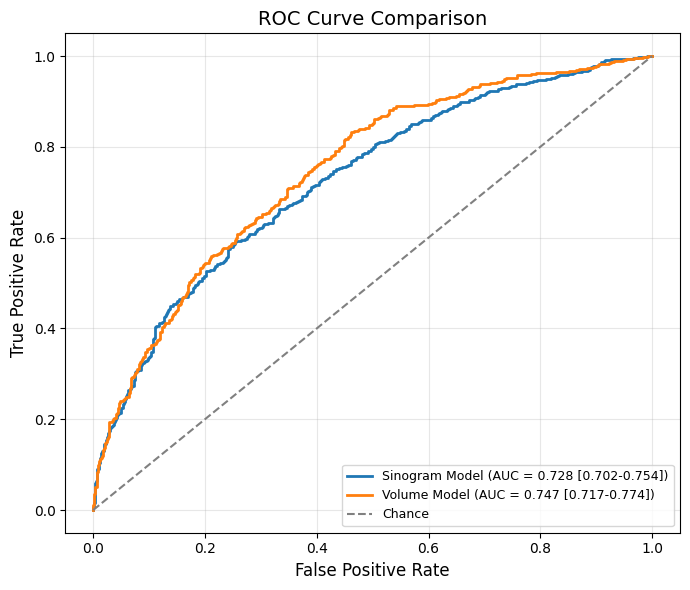

ROC comparison saved to results/roc_sino_vs_vol_densenet.png


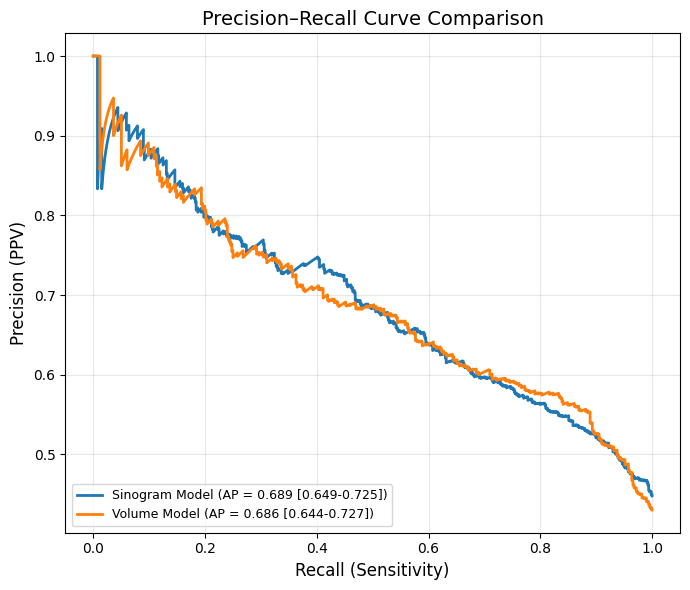

Precision–Recall comparison saved to results/pr_sino_vs_vol_densenet.png

=== Statistical Significance (Paired Bootstrap) ===
AUC Δ = -0.0189 [-0.0596, 0.0206], p = 0.3760
AP  Δ = 0.0027 [-0.0499, 0.0607], p = 0.9400
→ No significant difference detected.

=== Summary of Performance Metrics ===
Sinogram Model: AUC = 0.728 [0.702-0.754], AP = 0.689 [0.649-0.725]
Volume Model: AUC = 0.747 [0.717-0.774], AP = 0.686 [0.644-0.727]


In [158]:
compare_curves(
    results_dirs=["results/sino_eval/densenet", "results/vol_eval/densenet"],
    labels=["Sinogram Model", "Volume Model"],
    save_path_roc="results/roc_sino_vs_vol_densenet.png",
    save_path_pr="results/pr_sino_vs_vol_densenet.png"
)

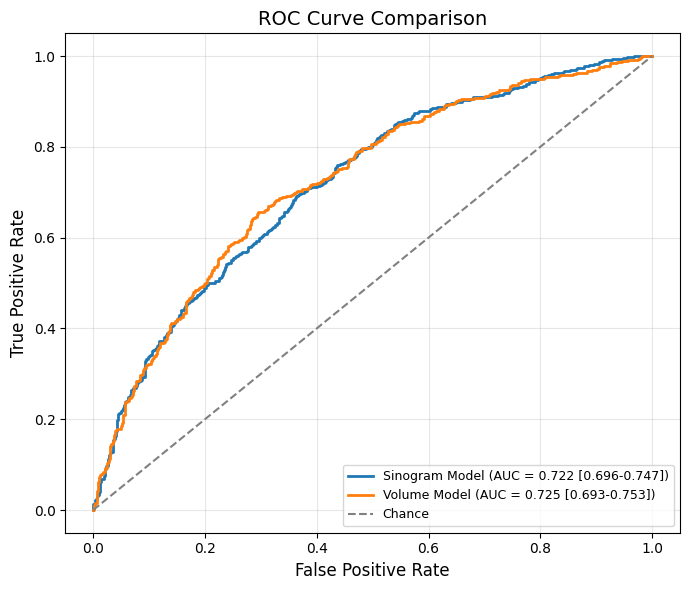

ROC comparison saved to results/roc_sino_vs_vol_resnet.png


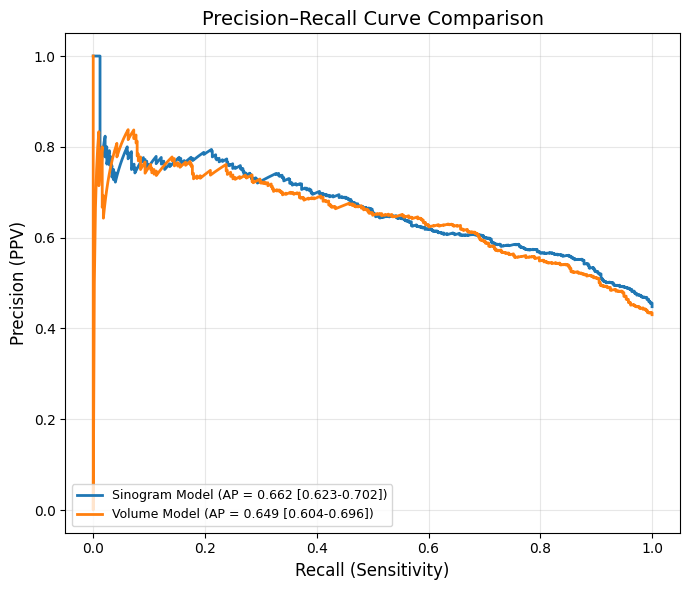

Precision–Recall comparison saved to results/pr_sino_vs_vol_resnet.png

=== Statistical Significance (Paired Bootstrap) ===
AUC Δ = -0.0029 [-0.0414, 0.0370], p = 0.8900
AP  Δ = 0.0130 [-0.0454, 0.0743], p = 0.6960
→ No significant difference detected.

=== Summary of Performance Metrics ===
Sinogram Model: AUC = 0.722 [0.696-0.747], AP = 0.662 [0.623-0.702]
Volume Model: AUC = 0.725 [0.693-0.753], AP = 0.649 [0.604-0.696]


In [159]:
compare_curves(
    results_dirs=["results/sino_eval/resnet", "results/vol_eval/resnet"],
    labels=["Sinogram Model", "Volume Model"],
    save_path_roc="results/roc_sino_vs_vol_resnet.png",
    save_path_pr="results/pr_sino_vs_vol_resnet.png"
)

In [180]:
def compare_model_performance(
    results_dirs,
    labels,
    prefixes=("eval", "eval"),
    save_csv="results/model_comparison_summary.csv",
    save_radar="results/model_comparison_radar.png",
    save_bars="results/model_comparison_errorbars.png",
    n_bootstrap=1000,
    random_state=42
):
    """
    Compare key metrics (AUC, AP, Accuracy, F1) between multiple models
    with 95% bootstrap confidence intervals, paired significance testing,
    and visualization via radar and error-bar plots.
    """

    rng = np.random.default_rng(random_state)
    all_metrics = {}
    bootstrap_scores = {}

    # --- Compute metrics and bootstrap CIs ---
    for dir_path, label in zip(results_dirs, labels):
        found = False
        for prefix in prefixes:
            true_path = os.path.join(dir_path, f"{prefix}_y_true.npy")
            prob_path = os.path.join(dir_path, f"{prefix}_y_prob.npy")
            pred_path = os.path.join(dir_path, f"{prefix}_y_pred.npy")
            if os.path.exists(true_path) and os.path.exists(prob_path) and os.path.exists(pred_path):
                found = True
                break

        if not found:
            print(f"No matching prediction files found for {label}, skipping.")
            continue

        y_true = np.load(true_path)
        y_prob = np.load(prob_path)
        y_pred = np.load(pred_path)

        auc = roc_auc_score(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # --- Bootstrap for 95% CIs ---
        auc_samples, ap_samples, acc_samples, f1_samples = [], [], [], []
        for _ in range(n_bootstrap):
            idx = rng.integers(0, len(y_true), len(y_true))
            try:
                auc_samples.append(roc_auc_score(y_true[idx], y_prob[idx]))
                ap_samples.append(average_precision_score(y_true[idx], y_prob[idx]))
                acc_samples.append(accuracy_score(y_true[idx], y_pred[idx]))
                f1_samples.append(f1_score(y_true[idx], y_pred[idx]))
            except ValueError:
                continue

        auc_ci = np.percentile(auc_samples, [2.5, 97.5])
        ap_ci  = np.percentile(ap_samples, [2.5, 97.5])
        acc_ci = np.percentile(acc_samples, [2.5, 97.5])
        f1_ci  = np.percentile(f1_samples, [2.5, 97.5])

        all_metrics[label] = {
            "AUC": auc, "AUC_CI": auc_ci,
            "AP": ap, "AP_CI": ap_ci,
            "Accuracy": acc, "Accuracy_CI": acc_ci,
            "F1": f1, "F1_CI": f1_ci
        }

        bootstrap_scores[label] = {
            "AUC": np.array(auc_samples),
            "AP": np.array(ap_samples),
            "Accuracy": np.array(acc_samples),
            "F1": np.array(f1_samples)
        }

        print(f"{label}: "
              f"AUC={auc:.3f} [{auc_ci[0]:.3f}-{auc_ci[1]:.3f}], "
              f"AP={ap:.3f} [{ap_ci[0]:.3f}-{ap_ci[1]:.3f}], "
              f"Acc={acc:.3f} [{acc_ci[0]:.3f}-{acc_ci[1]:.3f}], "
              f"F1={f1:.3f} [{f1_ci[0]:.3f}-{f1_ci[1]:.3f}]")

    if not all_metrics:
        print("No valid results found.")
        return None

    # --- Paired Bootstrap Significance Test (if 2 models) ---

    # --- Summary DataFrame ---
    df = pd.DataFrame({
        model: {
            "AUC": m["AUC"], "AP": m["AP"],
            "Accuracy": m["Accuracy"], "F1": m["F1"]
        } for model, m in all_metrics.items()
    }).T.round(3)

    print("\nPerformance Summary:")
    print(df)
    os.makedirs(os.path.dirname(save_csv), exist_ok=True)
    df.to_csv(save_csv)
    print(f"Saved summary to {save_csv}")

    # --- Radar Plot ---
    metrics_names = df.columns.tolist()
    num_vars = len(metrics_names)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    plt.title("Model Performance Comparison (Radar)", size=14, pad=20)

    for model_name, row in df.iterrows():
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics_names, fontsize=11)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.savefig(save_radar, bbox_inches="tight", dpi=150)
    plt.show()
    print(f"Radar plot saved to {save_radar}")

    # --- Bar Plot with 95% CI Error Bars ---
    plt.figure(figsize=(8, 6))
    metrics = ["AUC", "AP", "Accuracy", "F1"]
    x = np.arange(len(metrics))
    width = 0.35

    for i, label in enumerate(labels):
        means, lowers, uppers = [], [], []

        for m in metrics:
            mean_val = all_metrics[label].get(m, np.nan)
            ci_val = all_metrics[label].get(f"{m}_CI", [mean_val, mean_val])

            # Gracefully handle missing CI keys
            if ci_val is None or len(ci_val) < 2:
                ci_val = [mean_val, mean_val]

            means.append(mean_val)
            lowers.append(mean_val - ci_val[0])
            uppers.append(ci_val[1] - mean_val)

        err = np.array([lowers, uppers])
        plt.bar(x + i * width, means, width, yerr=err, capsize=5,
                label=label, alpha=0.8)

    plt.xticks(x + width / 2, metrics)
    plt.ylabel("Score")
    plt.title("Model Performance with 95% Confidence Intervals", fontsize=13)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_bars, bbox_inches="tight", dpi=150)
    plt.show()
    print(f"Error-bar plot saved to {save_bars}")

    return df

In [134]:
os.listdir("checkpoints")

['best_model.pt',
 'checkpoint_epoch3.pt',
 'volume_resnet3d_best.pt',
 'sinogram_resnet3d_best.pt',
 'checkpoint_epoch1.pt',
 'checkpoint_epoch2.pt']

In [135]:
model_sino_resnet = resnet18_3d(num_classes=2)
model_sino_resnet.load_state_dict(torch.load("checkpoints/sinogram_resnet3d_best.pt"))

<All keys matched successfully>

Sinogram Model: AUC=0.723, AP=0.676, Acc=0.601, F1=0.652
Volume Model: AUC=0.737, AP=0.677, Acc=0.630, F1=0.656

Performance Summary:
                  AUC     AP  Accuracy     F1
Sinogram Model  0.723  0.676     0.601  0.652
Volume Model    0.737  0.677     0.630  0.656
Saved summary to results/model_comparison_summary.csv


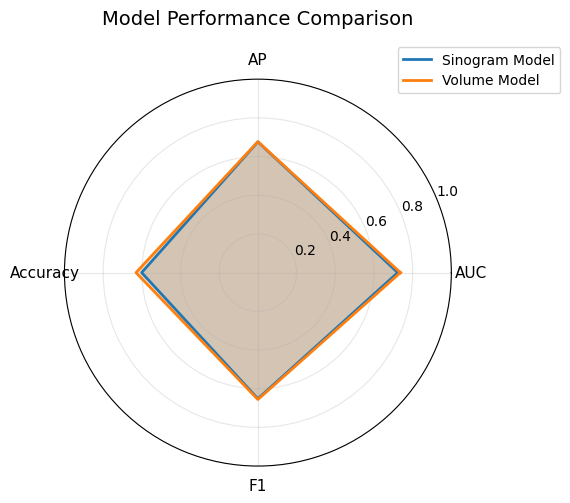

Radar plot saved to results/model_comparison_radar.png


In [136]:
df_compare = compare_model_performance(
    results_dirs=["results/sino_eval", "results/vol_eval"],
    labels=["Sinogram Model", "Volume Model"]
)

Sinogram Model: AUC=0.721 [0.696-0.747], AP=0.661 [0.621-0.700], Acc=0.615 [0.590-0.639], F1=0.671 [0.645-0.697]
Volume Model: AUC=0.726 [0.693-0.753], AP=0.647 [0.600-0.694], Acc=0.627 [0.598-0.655], F1=0.654 [0.621-0.684]

=== Statistical Significance (Paired Bootstrap) ===
AUC Δ = -0.0029 [-0.0414, 0.0370], p = 0.8900
→ No significant difference (CI includes 0).
AP Δ = 0.0132 [-0.0444, 0.0743], p = 0.6800
→ No significant difference (CI includes 0).
Accuracy Δ = -0.0115 [-0.0514, 0.0264], p = 0.5480
→ No significant difference (CI includes 0).
F1 Δ = 0.0176 [-0.0215, 0.0601], p = 0.3840
→ No significant difference (CI includes 0).

Performance Summary:
                  AUC     AP  Accuracy     F1
Sinogram Model  0.721  0.661     0.615  0.671
Volume Model    0.726  0.647     0.627  0.654
Saved summary to results/model_comparison_summary_resnet.csv


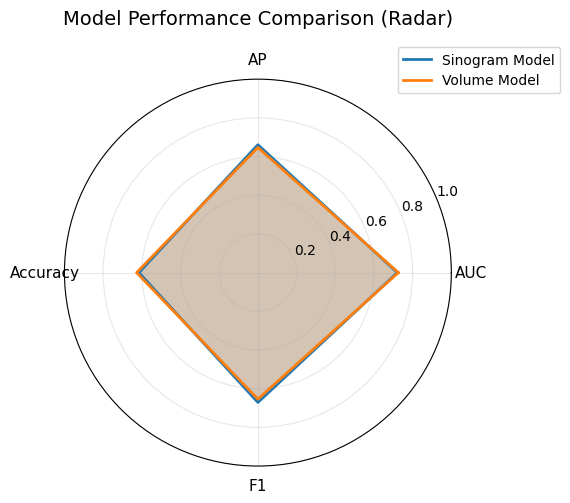

Radar plot saved to results/model_comparison_radar_resnet.png


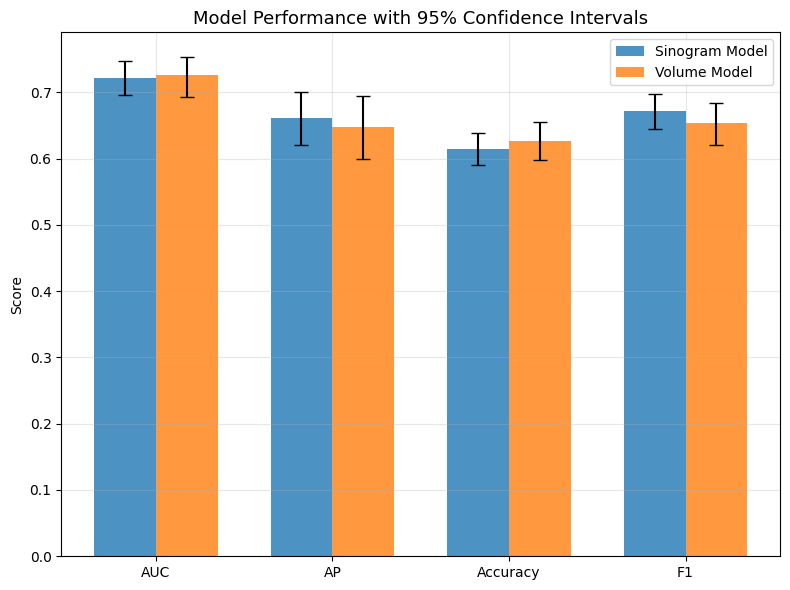

Error-bar plot saved to results/model_comparison_errorbars_resnet.png


In [181]:
df_compare = compare_model_performance(
    results_dirs=["results/sino_eval/resnet", "results/vol_eval/resnet"],
    labels=["Sinogram Model", "Volume Model"],
    save_csv="results/model_comparison_summary_resnet.csv",
    save_radar="results/model_comparison_radar_resnet.png",
    save_bars="results/model_comparison_errorbars_resnet.png"
)

Sinogram Model: AUC=0.727 [0.702-0.754], AP=0.687 [0.648-0.727], Acc=0.604 [0.579-0.630], F1=0.662 [0.635-0.688]
Volume Model: AUC=0.748 [0.717-0.774], AP=0.686 [0.642-0.726], Acc=0.648 [0.619-0.676], F1=0.680 [0.650-0.709]

=== Statistical Significance (Paired Bootstrap) ===
AUC Δ = -0.0189 [-0.0596, 0.0206], p = 0.3760
→ No significant difference (CI includes 0).
AP Δ = 0.0034 [-0.0579, 0.0609], p = 0.8840
→ No significant difference (CI includes 0).
Accuracy Δ = -0.0433 [-0.0812, -0.0066], p = 0.0240
→ Significant difference (CI excludes 0).
F1 Δ = -0.0169 [-0.0542, 0.0219], p = 0.4060
→ No significant difference (CI includes 0).

Performance Summary:
                  AUC     AP  Accuracy     F1
Sinogram Model  0.727  0.687     0.604  0.662
Volume Model    0.748  0.686     0.648  0.680
Saved summary to results/model_comparison_summary_densenet.csv


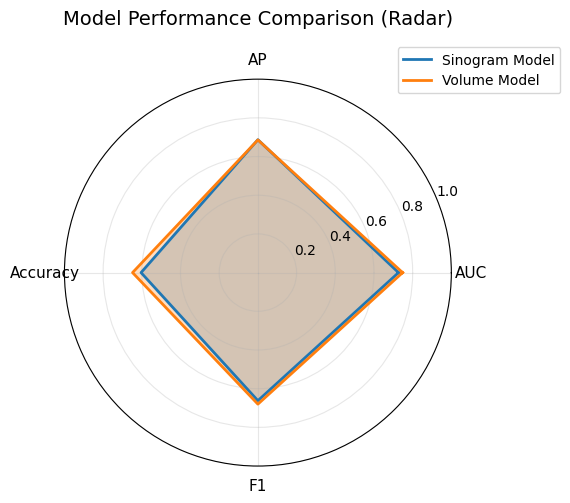

Radar plot saved to results/model_comparison_radar_densenet.png


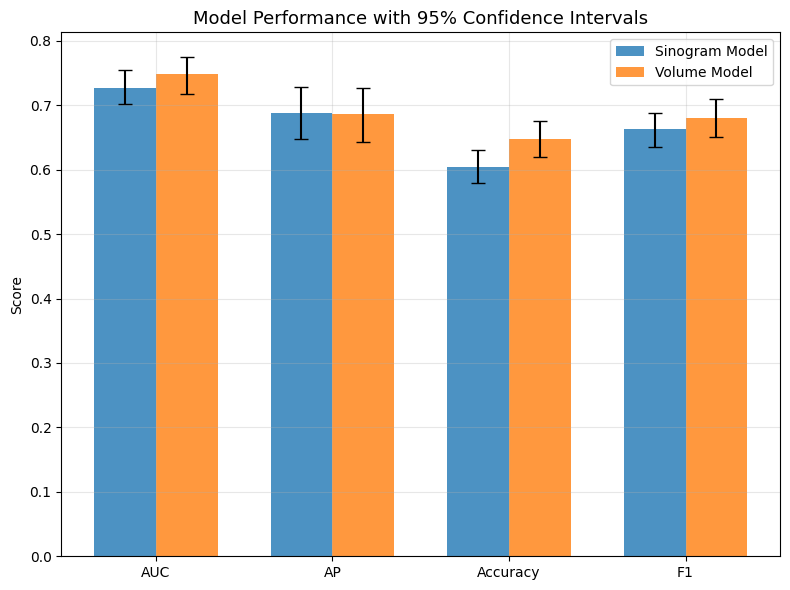

Error-bar plot saved to results/model_comparison_errorbars_densenet.png


In [182]:
df_compare = compare_model_performance(
    results_dirs=["results/sino_eval/densenet", "results/vol_eval/densenet"],
    labels=["Sinogram Model", "Volume Model"],
    save_csv="results/model_comparison_summary_densenet.csv",
    save_radar="results/model_comparison_radar_densenet.png",
    save_bars="results/model_comparison_errorbars_densenet.png"
)

In [137]:
def benchmark_inference(model, loader, n_batches=10, device=None, prefix="model"):
    """
    Benchmark inference runtime and memory for a model on given DataLoader.
    Args:
        model: torch.nn.Module (e.g., 3D ResNet)
        loader: DataLoader for test data
        n_batches: number of batches to average
        device: 'cuda' or 'cpu'
        prefix: label for saving
    Returns:
        dict with average time (s) and memory (MB)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)
    process = psutil.Process()
    times, mems = [], []

    with torch.no_grad():
        for i, (X, _) in enumerate(loader):
            if i >= n_batches:
                break
            X = X.to(device)
            start = time.time()
            _ = model(X)
            end = time.time()
            times.append(end - start)

            if torch.cuda.is_available():
                mem = torch.cuda.max_memory_allocated(device) / 1e6  # MB
                torch.cuda.reset_peak_memory_stats()
            else:
                mem = process.memory_info().rss / 1e6
            mems.append(mem)

    results = {
        "avg_time_s": float(np.mean(times)),
        "std_time_s": float(np.std(times)),
        "avg_mem_mb": float(np.mean(mems)),
    }
    print(f"[{prefix.upper()}] Avg Time: {results['avg_time_s']:.4f}s ±{results['std_time_s']:.4f}s | "
          f"Avg Mem: {results['avg_mem_mb']:.1f} MB")
    np.save(f"results/{prefix}_benchmark.npy", results)
    return results

In [138]:
bench_sino = benchmark_inference(model_sino_resnet, test_loader_sino, prefix="sino")
bench_vol = benchmark_inference(model_vol_resnet, test_loader_vol, prefix="vol")

[SINO] Avg Time: 0.0032s ±0.0001s | Avg Mem: 1279.6 MB
[VOL] Avg Time: 0.0033s ±0.0001s | Avg Mem: 1197.2 MB


In [225]:
def plot_conf_matrix(y_true, y_prob, thr=0.5, title="Confusion Matrix",
                     save_path=None, xlabels=None, ylabels=None):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    
    if xlabels is None:
        xlabels = ["Abnormal", "Normal"]  # default: 0=Abnormal, 1=Normal
    if ylabels is None:
        ylabels = ["Abnormal", "Normal"]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=xlabels)
    disp.plot(cmap="Blues", colorbar=False)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    disp.ax_.set_xticklabels(xlabels, rotation=0)
    disp.ax_.set_yticklabels(ylabels, rotation=90)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

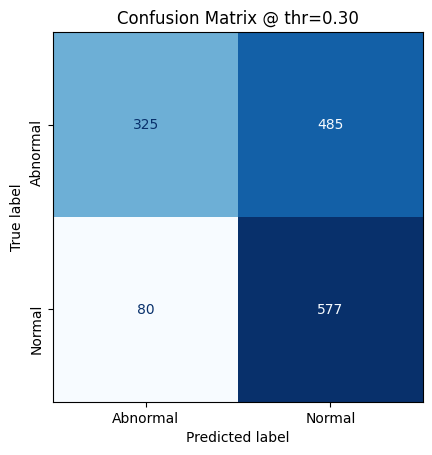

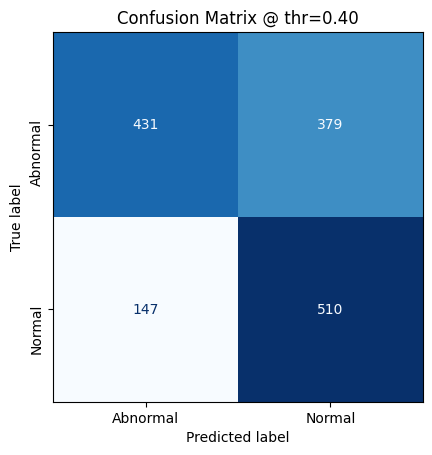

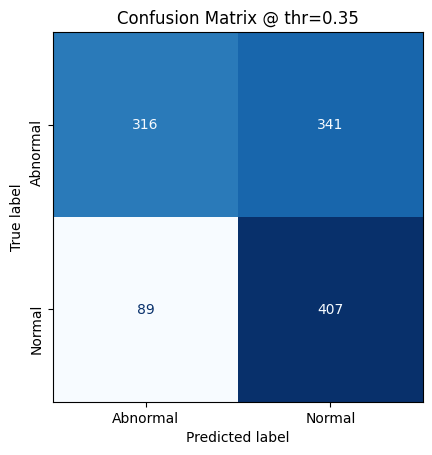

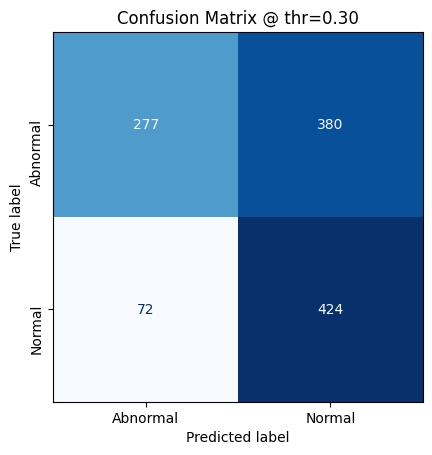

In [226]:
y_true_sino = np.load("results/sino_eval/resnet/uncal_eval_y_true.npy")
y_prob_sino = np.load("results/sino_eval/resnet/uncal_eval_y_prob.npy")

#uncal
# Use your optimized threshold
plot_conf_matrix(
    y_true_sino,
    y_prob_sino,
    thr=best_thr_sino_uncal,  # << use the model's best threshold
    title=f"Confusion Matrix @ thr={best_thr_sino_uncal:.2f}",
    save_path="results/sino_eval/resnet/uncal_sino_confusion.png",
    xlabels=["Abnormal", "Normal"], 
    ylabels=["Abnormal", "Normal"]
)
y_true_sino = np.load("results/sino_eval/resnet/cal_eval_y_true.npy")
y_prob_sino = np.load("results/sino_eval/resnet/cal_eval_y_prob.npy")

#cal
# Use your optimized threshold
plot_conf_matrix(
    y_true_sino,
    y_prob_sino,
    thr=best_thr_sino,  # << use the model's best threshold
    title= f"Confusion Matrix @ thr={best_thr_sino:.2f}",
    save_path="results/sino_eval/resnet/cal_sino_confusion.png",
    xlabels=["Abnormal", "Normal"], 
    ylabels=["Abnormal", "Normal"]
)

y_true_vol = np.load("results/vol_eval/resnet/uncal_eval_y_true.npy")
y_prob_vol = np.load("results/vol_eval/resnet/uncal_eval_y_prob.npy")

plot_conf_matrix(
    y_true_vol,
    y_prob_vol,
    thr=best_thr_volresnet,  # << use the model's best threshold
    title= f"Confusion Matrix @ thr={best_thr_volresnet:.2f}",
    save_path="results/vol_eval/resnet/uncal_vol_confusion.png",
    xlabels=["Abnormal", "Normal"], 
    ylabels=["Abnormal", "Normal"]
)

y_true_vol = np.load("results/vol_eval/resnet/cal_eval_y_true.npy")
y_prob_vol = np.load("results/vol_eval/resnet/cal_eval_y_prob.npy")

plot_conf_matrix(
    y_true_vol,
    y_prob_vol,
    thr=best_thr_vol,  # << use the model's best threshold
    title= f"Confusion Matrix @ thr={best_thr_vol:.2f}",
    save_path="results/vol_eval/resnet/cal_vol_confusion.png",
    xlabels=["Abnormal", "Normal"], 
    ylabels=["Abnormal", "Normal"]
)

In [235]:
def model_stats(model, input_size):
    macs, params = get_model_complexity_info(
        model,
        input_res=input_size,  # (C, H, W, D) for 3D CNN
        as_strings=False,
        verbose=False
    )
    params_m = params / 1e6
    macs_g = macs / 1e9
    print(f"Params: {params_m:.2f}M | FLOPs: {macs_g:.2f}G for input {input_size}")
    return params_m, macs_g

In [238]:
# 3D input shapes for your actual models
input_sino = (1, 192, 192, 96)
input_vol  = (1, 192, 192, 96)

# Compute stats
stats_sino = model_stats(model_sino_resnet, input_size=input_sino)
stats_vol  = model_stats(model_vol_resnet, input_size=input_vol)

np.save("results/model_stats.npy", {"sino": stats_sino, "vol": stats_vol})

VideoResNet(
  192.07 k, 0.579% Params, 11.02 GMac, 96.851% MACs, 
  (stem): BasicStem(
    9.54 k, 0.029% Params, 8.49 GMac, 74.650% MACs, 
    (0): Conv3d(9.41 k, 0.028% Params, 8.32 GMac, 73.157% MACs, 1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(128, 0.000% Params, 113.25 MMac, 0.995% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 56.62 MMac, 0.498% MACs, inplace=True)
  )
  (layer1): Sequential(
    512, 0.002% Params, 679.48 MMac, 5.972% MACs, 
    (0): BasicBlock(
      256, 0.001% Params, 339.74 MMac, 2.986% MACs, 
      (conv1): Sequential(
        128, 0.000% Params, 169.87 MMac, 1.493% MACs, 
        (0): Conv3DSimple(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(128, 0.000% Params, 113.25 MMac, 0.995% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [143]:
def visualize_gradcam_3d(model, loader, target_layer, prefix, slice_idx=None, num_samples=1):
    import os, torch, numpy as np, matplotlib.pyplot as plt
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval().to(device)
    cam = GradCAM(model=model, target_layers=[target_layer])

    os.makedirs("results", exist_ok=True)

    for i, (X, _) in enumerate(loader):
        if i >= num_samples:
            break
        X = X.to(device)
        grayscale_cam = cam(input_tensor=X)[0]
        grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

        # ✅ choose specific slice or middle automatically
        mid_slice = grayscale_cam.shape[0] // 2
        idx = slice_idx if slice_idx is not None else mid_slice

        cam_slice = grayscale_cam[idx]
        img_slice = X[0, 0, idx].detach().cpu().numpy()
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
        img_rgb = np.repeat(img_slice[..., None], 3, axis=-1)
        visualization = show_cam_on_image(img_rgb, cam_slice, use_rgb=True)

        plt.imshow(visualization)
        plt.axis("off")
        plt.title(f"{prefix.upper()} Grad-CAM (slice {idx})")
        plt.tight_layout()
        save_path = f"results/{prefix}_gradcam_slice{idx}.png"
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved → {save_path}")

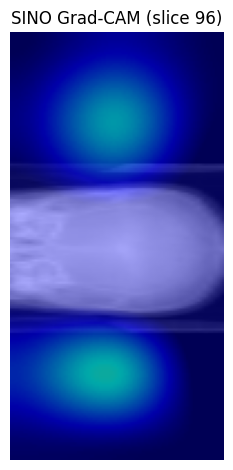

Saved → results/sino_gradcam_slice96.png


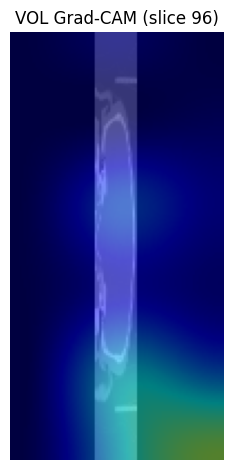

Saved → results/vol_gradcam_slice96.png


In [144]:
visualize_gradcam_3d(model_sino_resnet, test_loader_sino,
                     target_layer=model_sino_resnet.layer4[-1],
                     prefix="sino")

visualize_gradcam_3d(model_vol_resnet, test_loader_vol,
                     target_layer=model_vol_resnet.layer4[-1],
                     prefix="vol")

In [239]:
model_stats_path = "results/model_stats.npy"
bench_sino_path = "results/sino_benchmark.npy"
bench_vol_path  = "results/vol_benchmark.npy"

if not all(os.path.exists(p) for p in [model_stats_path, bench_sino_path, bench_vol_path]):
    raise FileNotFoundError("Run model_stats() and benchmark_inference() before generating the summary.")

stats = np.load(model_stats_path, allow_pickle=True).item()
bench_sino = np.load(bench_sino_path, allow_pickle=True).item()
bench_vol  = np.load(bench_vol_path,  allow_pickle=True).item()

# Build DataFrame dynamically
data = [
    {
        "Model": "Sinogram 3D ResNet",
        "Input": "1×192×192×96",
        "Params (M)": round(stats["sino"][0], 2),
        "FLOPs (G)": round(stats["sino"][1], 2),
        "Avg Time (s)": round(bench_sino["avg_time_s"], 4),
        "Memory (MB)": round(bench_sino["avg_mem_mb"], 1)
    },
    {
        "Model": "Volume 3D ResNet",
        "Input": "1×192×192×96",
        "Params (M)": round(stats["vol"][0], 2),
        "FLOPs (G)": round(stats["vol"][1], 2),
        "Avg Time (s)": round(bench_vol["avg_time_s"], 4),
        "Memory (MB)": round(bench_vol["avg_mem_mb"], 1)
    }
]

df = pd.DataFrame(data)
df["Relative Speed (%)"] = (df["Avg Time (s)"].min() / df["Avg Time (s)"] * 100).round(1)
df["Relative FLOPs (%)"] = (df["FLOPs (G)"] / df["FLOPs (G)"].max() * 100).round(1)

# Save results
os.makedirs("results", exist_ok=True)
df.to_csv("results/full_efficiency_summary.csv", index=False)
print(df)

                Model         Input  Params (M)  FLOPs (G)  Avg Time (s)  \
0  Sinogram 3D ResNet  1×192×192×96       33.15      11.38        0.0032   
1    Volume 3D ResNet  1×192×192×96       33.15      11.38        0.0033   

   Memory (MB)  Relative Speed (%)  Relative FLOPs (%)  
0       1279.6               100.0               100.0  
1       1197.2                97.0               100.0  


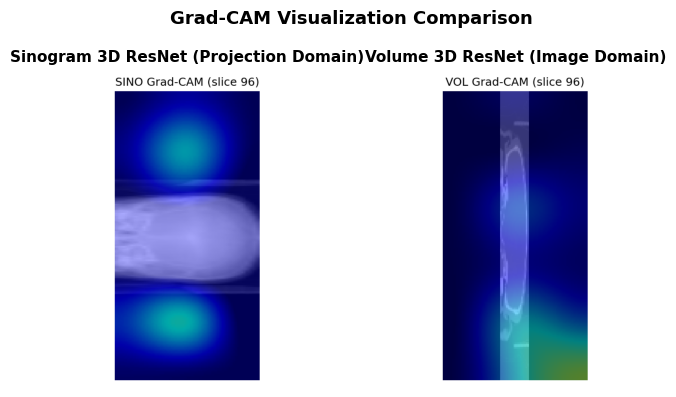

Displayed:
  results/sino_gradcam_slice96.png
  results/vol_gradcam_slice96.png


In [243]:
def display_latest_gradcams(results_dir="results"):
    imgs = [f for f in os.listdir(results_dir) if f.endswith(".png") and "gradcam" in f]
    if not imgs:
        raise FileNotFoundError("No Grad-CAM images found. Re-run visualize_gradcam_3d first.")
    sino_files = [os.path.join(results_dir, f) for f in imgs if f.startswith("sino")]
    vol_files  = [os.path.join(results_dir, f) for f in imgs if f.startswith("vol")]
    if not sino_files or not vol_files:
        raise FileNotFoundError("Both sinogram and volume Grad-CAMs are required.")
    sino_path = max(sino_files, key=os.path.getmtime)
    vol_path  = max(vol_files,  key=os.path.getmtime)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for ax, path, title in zip(
        axs,
        [sino_path, vol_path],
        ["Sinogram 3D ResNet (Projection Domain)", "Volume 3D ResNet (Image Domain)"]
    ):
        img = plt.imread(path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(title, fontsize=11, fontweight="semibold")
    fig.suptitle("Grad-CAM Visualization Comparison", fontsize=13, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()
    print(f"Displayed:\n  {sino_path}\n  {vol_path}")

# Run this once both Grad-CAMs are generated:
display_latest_gradcams()

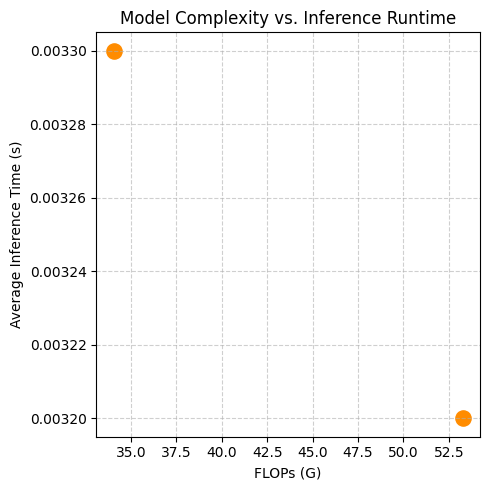

In [147]:
plt.figure(figsize=(5,5))
plt.scatter(df["FLOPs (G)"], df["Avg Time (s)"], s=120, color="darkorange")
for i, row in df.iterrows():
    plt.annotate(row["Model"], (row["FLOPs (G)"]+0.5, row["Avg Time (s)"]+0.002))
plt.xlabel("FLOPs (G)")
plt.ylabel("Average Inference Time (s)")
plt.title("Model Complexity vs. Inference Runtime")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("results/complexity_vs_runtime.png", dpi=200, bbox_inches="tight")
plt.show()

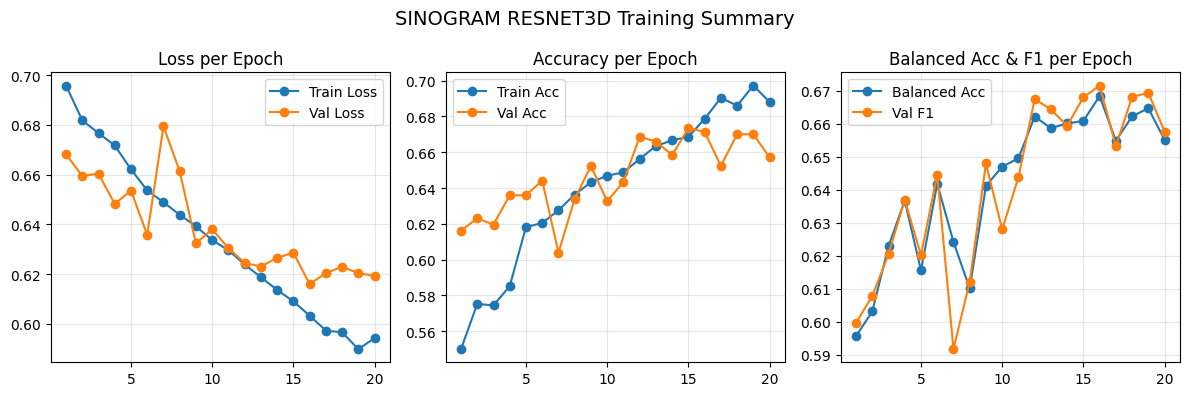

In [228]:
# --- Path to your saved metrics file ---
csv_path = "results/sinogram_resnet3d_training_metrics.csv"

# --- Load training history ---
df = pd.read_csv(csv_path)

# --- Plot training curves ---
epochs = range(1, len(df) + 1)
plt.figure(figsize=(12, 4))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, df["train_loss"], 'o-', label="Train Loss")
plt.plot(epochs, df["val_loss"], 'o-', label="Val Loss")
plt.title("Loss per Epoch"); plt.legend(); plt.grid(alpha=0.3)

# 2. Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, df["train_acc"], 'o-', label="Train Acc")
plt.plot(epochs, df["val_acc"], 'o-', label="Val Acc")
plt.title("Accuracy per Epoch"); plt.legend(); plt.grid(alpha=0.3)

# 3. Balanced Accuracy & F1
plt.subplot(1, 3, 3)
plt.plot(epochs, df["val_balacc"], 'o-', label="Balanced Acc")
plt.plot(epochs, df["val_f1"], 'o-', label="Val F1")
plt.title("Balanced Acc & F1 per Epoch"); plt.legend(); plt.grid(alpha=0.3)

# --- Final touches ---
plt.suptitle("SINOGRAM RESNET3D Training Summary", fontsize=14)
plt.tight_layout()
plt.show()

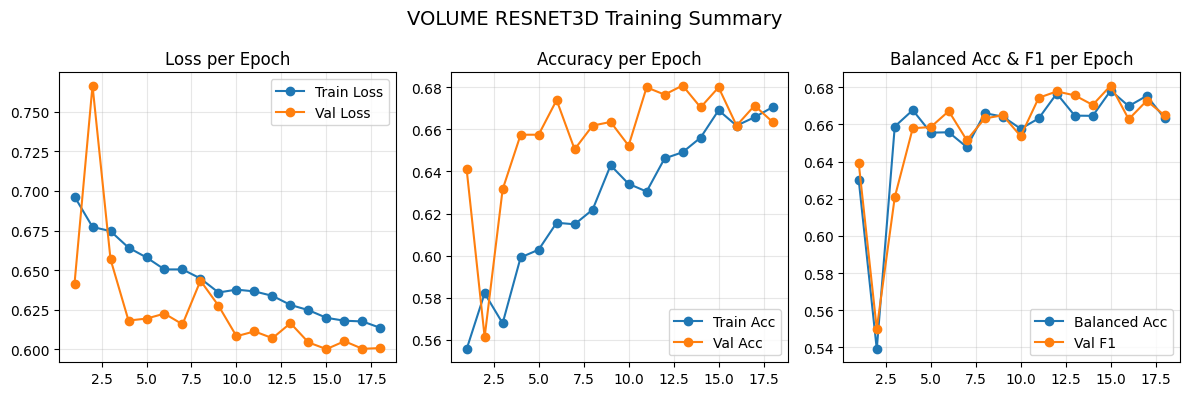

In [229]:
# --- Path to your saved metrics file ---
csv_path = "results/volume_resnet3d_training_metrics.csv"  # change as needed

# --- Load training history ---
df = pd.read_csv(csv_path)

# --- Plot training curves ---
epochs = range(1, len(df) + 1)
plt.figure(figsize=(12, 4))

# 1. Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, df["train_loss"], 'o-', label="Train Loss")
plt.plot(epochs, df["val_loss"], 'o-', label="Val Loss")
plt.title("Loss per Epoch"); plt.legend(); plt.grid(alpha=0.3)

# 2. Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, df["train_acc"], 'o-', label="Train Acc")
plt.plot(epochs, df["val_acc"], 'o-', label="Val Acc")
plt.title("Accuracy per Epoch"); plt.legend(); plt.grid(alpha=0.3)

# 3. Balanced Accuracy & F1
plt.subplot(1, 3, 3)
plt.plot(epochs, df["val_balacc"], 'o-', label="Balanced Acc")
plt.plot(epochs, df["val_f1"], 'o-', label="Val F1")
plt.title("Balanced Acc & F1 per Epoch"); plt.legend(); plt.grid(alpha=0.3)

# --- Final touches ---
plt.suptitle("VOLUME RESNET3D Training Summary", fontsize=14)
plt.tight_layout()
plt.show()